# Frontal Detection Analysis (Extreme Precip)

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import xesmf as xe
import nc_time_axis
import cftime # need cftime < 1.5 or nc-time-axis won't work (https://github.com/SciTools/nc-time-axis/issues/58)
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

In [2]:
# Import dask
import dask

# Use dask jobqueue
from dask_jobqueue import PBSCluster

# Import a client
from dask.distributed import Client

# Setup your PBSCluster
cluster = PBSCluster(
    cores=1, # The number of cores you want
    memory='10GB', # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus=1:mem=10GB', # Specify resources
    project='P06010014', # Input your project ID here
    walltime='04:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up -- how to determine this number?
# Here asking for 10 nodes (10 dask workers)
cluster.scale(10)

# Adaptive scaling option!
#cluster.adapt(minimum=1, maximum=100, wait_count=60)

# Change your url to the dask dashboard so you can see it
dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})

# Setup your client
client = Client(cluster)

/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/dask_jobqueue/core.py:19: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile
/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/dask_jobqueue/core.py:19: FutureWarning: parse_bytes is deprecated and will be removed in a future release. Please use dask.utils.parse_bytes instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile
/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/dask_jobqueue/htcondor.py:6: FutureWarning: parse_bytes is deprecated and will be removed in a future release. Please use dask.utils.parse_bytes instead.
  from distributed.utils import parse_bytes
/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluste

In [3]:
client

Connection method: Cluster object,Cluster type: PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/39993/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/39993/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.46:46538,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/39993/status,Total threads: 0
Started: Just now,Total memory: 0 B


### Close cluster/client as needed
Do I need both these commands?

In [ ]:
client.close()
cluster.close()

### Set fronts filepath

In [4]:
cesm_fronts_filepath = "/glade/work/kdagon/FrontDetector/CESMOutputs/"

## CESM historical/RCP2.6 simulation, 2000-2015

In [5]:
#onehot_file = "cesm_frontsOneHot_2000-2005.nc"
#onehot_file = "cesm_frontsOneHot_2000-2015.nc"
MN_file = "cesm_fronts_2000-2015_MaskedNetCDF_customgrid.nc"

In [6]:
#onehot = xr.open_dataset(cesm_fronts_filepath+onehot_file, chunks={'time':360}) # aim for chunk size < 100mb
MN = xr.open_dataset(cesm_fronts_filepath+MN_file, chunks={'time':360})

In [ ]:
#fronts = onehot.fronts
#fronts
#fronts.front
#fronts.isel(time=100, front=4).plot()

In [7]:
fronts_MN = MN.fronts

In [ ]:
fronts_MN.isel(time=100, front=4).plot()

Extract most likely front from onehot (via argmax)

In [8]:
#allfronts = fronts.argmax(dim='front')
allfronts = fronts_MN.argmax(dim='front')

In [ ]:
allfronts

### Read in precipitation field

NOTE: If already processed, can skip to reading in regridded files below

In [10]:
cesm_hist_filepath = "/glade/campaign/cgd/ccr/kdagon/dlfront/B20TRC5CN/" # need to be on casper, CESM historical output
cesm_rcp26_filepath = "/glade/campaign/cgd/ccr/kdagon/dlfront/BRCP26C5CN/" # RCP2.6 output

options for 3hrly avg and instantaneous PRECT

In [24]:
# h4.PRECT is 3hrly instantaneous
# h3.PRECT is 3hrly average
# remapped from unstructured grid to FV (still 1/4 degree so will not completely match frontal ID)

#PRECT_hist_files = "b.e13.B20TRC5CN.ne120_g16.003.cam.h4.PRECT*FV.nc"
PRECT_hist_files = "b.e13.B20TRC5CN.ne120_g16.003.cam.h3.PRECT*regrid*"
#PRECT_rcp26_files = "b.e13.BRCP26C5CN.ne120_g16.003.cam.h4.PRECT*FV.nc"
PRECT_rcp26_files = "b.e13.BRCP26C5CN.ne120_g16.003.cam.h3*PRECT.regrid*"

preprocessing function to return PRECT only over North American domain

In [25]:
def preprocess(ds):
    #return ds['PRECT']
    return ds['PRECT'].sel(lat=slice(10,77),lon=slice(189,329))
    # option for retaining bounds for conservative regridding - not working at this time
    #PRECT = ds['PRECT'].sel(lat=slice(10,77),lon=slice(189,329))
    #lat_bnds = ds['lat_bnds'].sel(lat=slice(10,77))
    #lon_bnds = ds['lon_bnds'].sel(lon=slice(189,329))
    #ds_new = xr.merge([PRECT,lat_bnds,lon_bnds])
    #return ds_new

read in PRECT files with preprocessing function

In [26]:
%%time
PRECT_hist = xr.open_mfdataset(cesm_hist_filepath+PRECT_hist_files, concat_dim='time', combine="nested", chunks={'time':150}, parallel=True, preprocess=preprocess)
PRECT_rcp26 = xr.open_mfdataset(cesm_rcp26_filepath+PRECT_rcp26_files, concat_dim='time', combine="nested", chunks={'time':150}, parallel=True, preprocess=preprocess)

CPU times: user 1.34 s, sys: 42.4 ms, total: 1.38 s
Wall time: 17.2 s


In [27]:
PRECT_hist

<xarray.DataArray 'PRECT' (time: 17520, lat: 285, lon: 448)>
dask.array<concatenate, shape=(17520, 285, 448), dtype=float32, chunksize=(150, 285, 448), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 10.21 10.44 10.68 10.91 ... 76.15 76.39 76.62 76.86
  * lon      (lon) float64 189.1 189.4 189.7 190.0 ... 327.8 328.1 328.4 328.8
  * time     (time) object 2000-01-01 03:00:00 ... 2006-01-01 00:00:00
Attributes:
    units:          m/s
    long_name:      Total (convective and large-scale) precipitation rate (li...
    cell_methods:   time: mean
    cell_measures:  area: area

drop the final time index from hist (repeats)

In [28]:
PRECT_hist = PRECT_hist[:-1,:,:]
PRECT_hist

<xarray.DataArray 'PRECT' (time: 17519, lat: 285, lon: 448)>
dask.array<getitem, shape=(17519, 285, 448), dtype=float32, chunksize=(150, 285, 448), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 10.21 10.44 10.68 10.91 ... 76.15 76.39 76.62 76.86
  * lon      (lon) float64 189.1 189.4 189.7 190.0 ... 327.8 328.1 328.4 328.8
  * time     (time) object 2000-01-01 03:00:00 ... 2005-12-31 21:00:00
Attributes:
    units:          m/s
    long_name:      Total (convective and large-scale) precipitation rate (li...
    cell_methods:   time: mean
    cell_measures:  area: area

In [29]:
PRECT_rcp26

<xarray.DataArray 'PRECT' (time: 29200, lat: 285, lon: 448)>
dask.array<concatenate, shape=(29200, 285, 448), dtype=float32, chunksize=(150, 285, 448), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 10.21 10.44 10.68 10.91 ... 76.15 76.39 76.62 76.86
  * lon      (lon) float64 189.1 189.4 189.7 190.0 ... 327.8 328.1 328.4 328.8
  * time     (time) object 2006-01-01 00:00:00 ... 2015-12-31 21:00:00
Attributes:
    units:          m/s
    long_name:      Total (convective and large-scale) precipitation rate (li...
    cell_methods:   time: mean
    cell_measures:  area: area

### Combine precip for historical/rcp2.6

In [30]:
PRECT = xr.concat([PRECT_hist, PRECT_rcp26], dim='time')
PRECT

<xarray.DataArray 'PRECT' (time: 46719, lat: 285, lon: 448)>
dask.array<concatenate, shape=(46719, 285, 448), dtype=float32, chunksize=(150, 285, 448), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 10.21 10.44 10.68 10.91 ... 76.15 76.39 76.62 76.86
  * lon      (lon) float64 189.1 189.4 189.7 190.0 ... 327.8 328.1 328.4 328.8
  * time     (time) object 2000-01-01 03:00:00 ... 2015-12-31 21:00:00
Attributes:
    units:          m/s
    long_name:      Total (convective and large-scale) precipitation rate (li...
    cell_methods:   time: mean
    cell_measures:  area: area

In [103]:
p90_hires = PRECT_hist.chunk({'time': -1}).quantile(0.9, dim='time') # limiting to hist for now to avoid memory issues
p90_hires

<xarray.DataArray 'PRECT' (lat: 285, lon: 448)>
dask.array<getitem, shape=(285, 448), dtype=float64, chunksize=(285, 448), chunktype=numpy.ndarray>
Coordinates:
  * lat       (lat) float64 10.21 10.44 10.68 10.91 ... 76.15 76.39 76.62 76.86
  * lon       (lon) float64 189.1 189.4 189.7 190.0 ... 327.8 328.1 328.4 328.8
    quantile  float64 0.9

In [105]:
PEx_hires = PRECT_hist.where(PRECT_hist > p90_hires)
PEx_hires

<xarray.DataArray 'PRECT' (time: 17519, lat: 285, lon: 448)>
dask.array<where, shape=(17519, 285, 448), dtype=float32, chunksize=(150, 285, 448), chunktype=numpy.ndarray>
Coordinates:
  * lat       (lat) float64 10.21 10.44 10.68 10.91 ... 76.15 76.39 76.62 76.86
  * lon       (lon) float64 189.1 189.4 189.7 190.0 ... 327.8 328.1 328.4 328.8
  * time      (time) object 2000-01-01 03:00:00 ... 2005-12-31 21:00:00
    quantile  float64 0.9
Attributes:
    units:          m/s
    long_name:      Total (convective and large-scale) precipitation rate (li...
    cell_measures:  area: area

In [48]:
# rename bounds variables for conservative regridder
#PRECT = PRECT.rename({'lat_bnds':'lat_b', 'lon_bnds':'lon_b'})

### Regridding precipitation output to match fronts

In [31]:
%%time
regridder_bil = xe.Regridder(PRECT, allfronts, 'bilinear') # bilinear interpolation
#regridder_cons = xe.Regridder(PRECT, allfronts, 'conservative') # conservative - not working at this time

/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


CPU times: user 1min 5s, sys: 404 ms, total: 1min 6s
Wall time: 1min 5s


In [32]:
regridder_bil

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_285x448_68x141.nc 
Reuse pre-computed weights? False 
Input grid shape:           (285, 448) 
Output grid shape:          (68, 141) 
Periodic in longitude?      False

In [33]:
PRECT_1deg_bil = regridder_bil(PRECT)
#PRECT_1deg_cons = regridder_cons(PRECT)

/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


In [34]:
PRECT_1deg_bil

<xarray.DataArray 'PRECT' (time: 46719, lat: 68, lon: 141)>
dask.array<transpose, shape=(46719, 68, 141), dtype=float64, chunksize=(150, 68, 141), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2000-01-01 03:00:00 ... 2015-12-31 21:00:00
  * lon      (lon) float64 -171.0 -170.0 -169.0 -168.0 ... -33.0 -32.0 -31.0
  * lat      (lat) float64 10.0 11.0 12.0 13.0 14.0 ... 73.0 74.0 75.0 76.0 77.0
Attributes:
    regrid_method:  bilinear

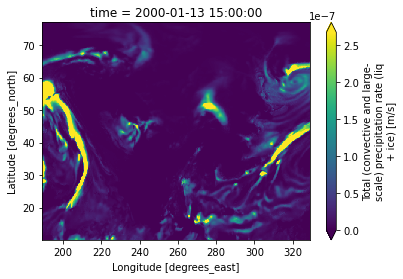

In [35]:
# high res (0.25deg)
PRECT.isel(time=100).plot(robust=True);

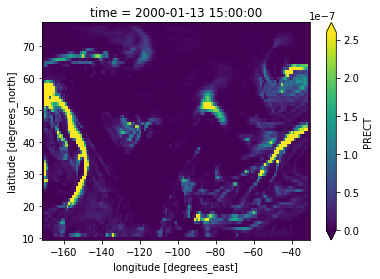

In [36]:
# low res (1deg)
PRECT_1deg_bil.isel(time=100).plot(robust=True);

### Save out regional, concatenated, regridded file to prevent Dask memory issues

In [11]:
postprocessing_filepath = '/glade/campaign/cgd/ccr/kdagon/dlfront/postprocessing/'

In [38]:
#PRECT_1deg_bil.to_netcdf(postprocessing_filepath+'PRECT_NA_hist_rcp26_1deg_bil.nc', mode='w', format='NETCDF4')
PRECT_1deg_bil.to_netcdf(postprocessing_filepath+'PRECT_3hravg_NA_hist_rcp26_1deg_bil.nc', mode='w', format='NETCDF4')

In [41]:
# needed if intemediate file has already been read in
#del PRECT_1deg

### Read back in intermediate file

This time, include lat/lon chunks to help with quantile calculation

In [9]:
postprocessing_filepath = '/glade/campaign/cgd/ccr/kdagon/dlfront/postprocessing/'

In [10]:
%%time
#PRECT_1deg = xr.open_dataarray(postprocessing_filepath+'PRECT_NA_hist_rcp26_1deg_bil.nc', chunks={'time':600, 'lat':10, 'lon':20})
PRECT_1deg = xr.open_dataarray(postprocessing_filepath+'PRECT_3hravg_NA_hist_rcp26_1deg_bil.nc', chunks={'time':600, 'lat':10, 'lon':20})

CPU times: user 194 ms, sys: 6.81 ms, total: 201 ms
Wall time: 304 ms


In [ ]:
PRECT_1deg

### Calculate 90th percentile precipitation at each gridpoint

In [11]:
p90 = PRECT_1deg.chunk({'time': -1}).quantile(0.9, dim='time')
#p90 = PRECT_1deg.quantile(0.9, dim='time') # cannot be chunked in time to calculate quantiles

In [ ]:
p90

### Select gridpoints where precipitation at a given time is greater than p90

In [12]:
PEx = PRECT_1deg.where(PRECT_1deg > p90)

In [101]:
PEx

,Array,Chunk
Bytes,3.34 GiB,0.92 MiB
Shape,"(46719, 68, 141)","(600, 10, 20)"
Count,13553 Tasks,4368 Chunks
Type,float64,numpy.ndarray


In [ ]:
%%time
(PEx.sel(time='2000-08-21T21')*1000*86400).plot(robust=True);

### Custom precip colormap from unidata
https://unidata.github.io/python-gallery/examples/Precipitation_Map.html \
Can skip this section if need be - just for making illustrative process plots

In [7]:
import matplotlib.colors as mcolors
clevs = [0, 1, 2.5, 5, 7.5, 10, 15, 20, 30, 40,
         50, 70, 100, 150, 200, 250, 300, 400, 500, 600, 750]
cmap_data = [(1.0, 1.0, 1.0),
             (0.3137255012989044, 0.8156862854957581, 0.8156862854957581),
             (0.0, 1.0, 1.0),
             (0.0, 0.8784313797950745, 0.501960813999176),
             (0.0, 0.7529411911964417, 0.0),
             (0.501960813999176, 0.8784313797950745, 0.0),
             (1.0, 1.0, 0.0),
             (1.0, 0.6274510025978088, 0.0),
             (1.0, 0.0, 0.0),
             (1.0, 0.125490203499794, 0.501960813999176),
             (0.9411764740943909, 0.250980406999588, 1.0),
             (0.501960813999176, 0.125490203499794, 1.0),
             (0.250980406999588, 0.250980406999588, 1.0),
             (0.125490203499794, 0.125490203499794, 0.501960813999176),
             (0.125490203499794, 0.125490203499794, 0.125490203499794),
             (0.501960813999176, 0.501960813999176, 0.501960813999176),
             (0.8784313797950745, 0.8784313797950745, 0.8784313797950745),
             (0.9333333373069763, 0.8313725590705872, 0.7372549176216125),
             (0.8549019694328308, 0.6509804129600525, 0.47058823704719543),
             (0.6274510025978088, 0.42352941632270813, 0.23529411852359772),
             (0.4000000059604645, 0.20000000298023224, 0.0)]
cmap_prec = mcolors.ListedColormap(cmap_data, 'precipitation')
norm_prec = mcolors.BoundaryNorm(clevs, cmap_prec.N)

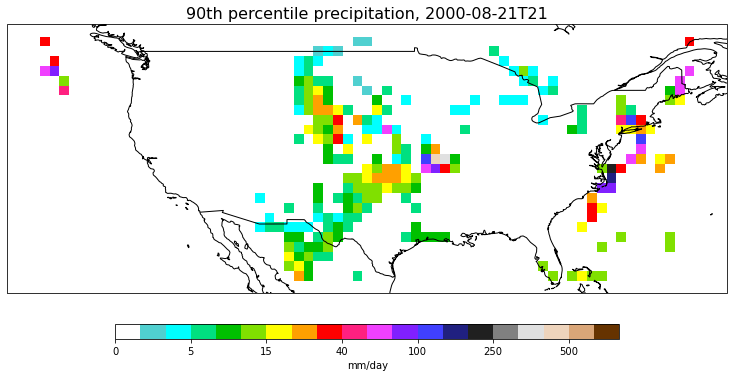

In [10]:
# clean up plot
fig = plt.figure(figsize=(10,10))

#ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax = fig.add_axes([0.,0.,1.,1.], projection=ccrs.PlateCarree())

ax.coastlines()
ax.add_feature(cfeature.BORDERS)

# select time index
#t = '2000-07-05T12'
t = '2000-08-21T21'

# highres field
#pfield = PRECT.sel(time=t, lat=slice(26,50), lon=slice(235,292))[0]*1000*86400
#pfield = PEx_hires.sel(time=t, lat=slice(26,50), lon=slice(235,292))[0]*1000*86400

# lowres field; extend the longitude range to force the map to plot the west coast
#pfield = PRECT_1deg.sel(time=t, lat=slice(26,50), lon=slice(-133,-68))[0]*1000*86400
pfield = PEx.sel(time=t, lat=slice(26,50), lon=slice(-133,-68))[0]*1000*86400
field, lon = add_cyclic_point(pfield, coord=pfield.lon)
lat = pfield.lat

#c_prec = ax.contourf(lon, lat, field, clevs, cmap=cmap_prec, norm=norm_prec, transform=ccrs.PlateCarree())
c_prec = ax.pcolormesh(lon, lat, field, cmap=cmap_prec, norm=norm_prec, transform=ccrs.PlateCarree())


# precip colorbar
cbar_prec_ax = fig.add_axes([0.15, 0.25, 0.7, 0.02])
cbar_prec = plt.colorbar(c_prec, cax=cbar_prec_ax, orientation='horizontal')
cbar_prec.set_label('mm/day')

# add title
#ax.set_title('Precipitation, '+t, fontsize=16);
ax.set_title('90th percentile precipitation, '+t, fontsize=16);

#plt.savefig('../figures/toSCP/PRECT_CESM_2000-08-21-21.pdf', bbox_inches='tight')
#plt.savefig('../figures/toSCP/PRECT_1deg_CESM_2000-08-21-21.pdf', bbox_inches='tight')
#plt.savefig('../figures/toSCP/PEx_CESM_2000-08-21-21.pdf', bbox_inches='tight')
#plt.savefig('../figures/toSCP/PEx_CESM_2000-08-21-21_pcolor.pdf', bbox_inches='tight')

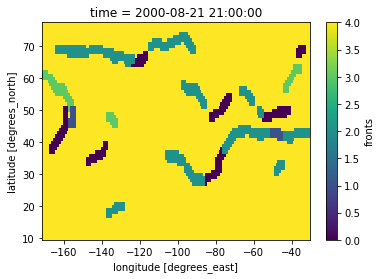

In [74]:
# fronts at the same time index
allfronts.sel(time=t).plot();

In [81]:
# making a custom fronts colorbar with blue for cold, red for warm, grey for stationary, 
# purple for occluded, and white for none fronts.

cmap_all = mpl.colors.ListedColormap(['blue', 'red', 'grey', 'purple', 'w'])
bounds = [0, 0.99, 1.99, 2.99, 3.99, 4.99]
norm_all = mpl.colors.BoundaryNorm(bounds, cmap_all.N)

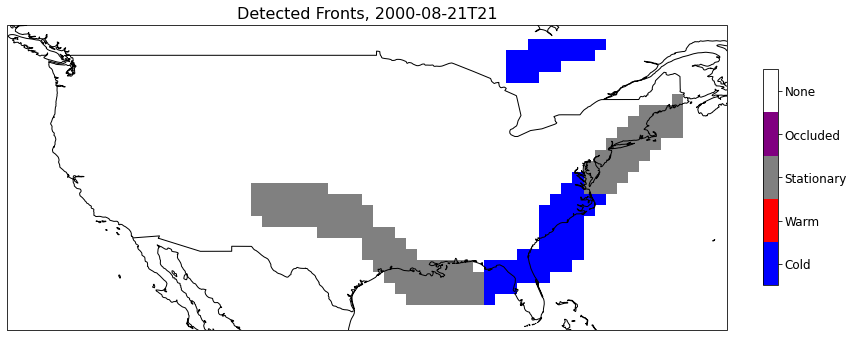

In [90]:
# clean up plot 

fig = plt.figure(figsize=(10,10))

ax = fig.add_axes([0.,0.,1.,1.], projection=ccrs.PlateCarree())

ax.coastlines()
ax.add_feature(cfeature.BORDERS)

# select time index
#t = '2000-07-05T12'
t = '2000-08-21T21'

ffield = allfronts.sel(time=t, lat=slice(26,50), lon=slice(-125,-68))[0]
field, lon = add_cyclic_point(ffield, coord=ffield.lon)
lat = ffield.lat
cf = ax.pcolormesh(lon, lat, field, cmap=cmap_all, vmin=0, vmax=4.99, norm=norm_all, transform=ccrs.PlateCarree())

# fronts colorbar
cbar_ax = fig.add_axes([1.05, 0.35, 0.02, 0.3])
norm_all_cb = mpl.colors.Normalize(vmin=0, vmax=4.99)
cb1 = mpl.colorbar.ColorbarBase(cbar_ax, 
                                cmap=cmap_all,
                                norm=norm_all_cb,
                                orientation='vertical', 
                               ticks=bounds)
labels = np.array([0, 0.99, 1.99, 2.99, 3.99])
loc    = labels + .5
tick_1 = ['Cold','Warm','Stationary','Occluded','None']
cb1.set_ticks(loc)
cb1.ax.set_yticklabels(tick_1)
cb1.ax.tick_params(labelsize=12)

# add title
ax.set_title('Detected Fronts, '+t, fontsize=16);

#plt.savefig('../figures/toSCP/allfronts_CESM_2000-08-21-21.pdf', bbox_inches='tight')

### Make a front mask (any/none)

In [13]:
anyfront = allfronts.where(allfronts < 4)

In [ ]:
anyfront.sel(time='2000-08-21T21').plot();

### Find gridpoints that overlap (front & PEx)

In [14]:
PEx_front = PEx.where(anyfront.notnull())

In [23]:
PEx_front

,Array,Chunk
Bytes,3.34 GiB,562.50 kiB
Shape,"(46719, 68, 141)","(360, 10, 20)"
Count,65554 Tasks,10192 Chunks
Type,float64,numpy.ndarray


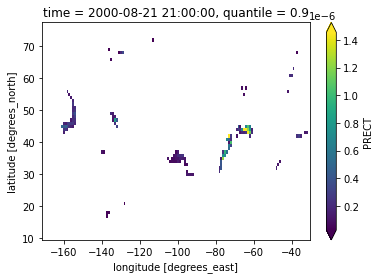

In [24]:
# PEx associated with fronts (overlapping gridpoints)
PEx_front.sel(time='2000-08-21T21').plot(robust=True);

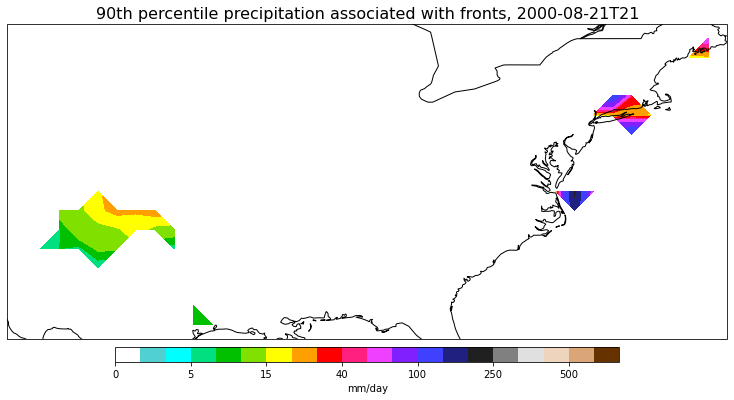

In [82]:
# clean up plot

fig = plt.figure(figsize=(10,10))

#ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax = fig.add_axes([0.,0.,1.,1.], projection=ccrs.PlateCarree())

ax.coastlines()
ax.add_feature(cfeature.BORDERS)

# select time index
#t = '2000-07-05T12'
t = '2000-08-21T21'

# extend the longitude range to force the map to plot the west coast
pfield = PEx_front.sel(time=t, lat=slice(26,50), lon=slice(-125,-68))[0]*1000*86400
#pfield = PEx_front.sel(time=t)[0]*1000*86400
field, lon = add_cyclic_point(pfield, coord=pfield.lon)
lat = pfield.lat
c_prec = ax.contourf(lon, lat, field, clevs, cmap=cmap_prec, norm=norm_prec, transform=ccrs.PlateCarree())
#ax.clabel(cf_prec, inline=1, fontsize=10)

# precip colorbar
cbar_prec_ax = fig.add_axes([0.15, 0.25, 0.7, 0.02])
cbar_prec = plt.colorbar(c_prec, cax=cbar_prec_ax, orientation='horizontal')
cbar_prec.set_label('mm/day')

# add title
#ax.set_title('Precipitation, '+t, fontsize=16);
ax.set_title('90th percentile precipitation associated with fronts, '+t, fontsize=16);

#plt.savefig('../figures/toSCP/PEx_front_CESM_2000-08-21-21.pdf', bbox_inches='tight')

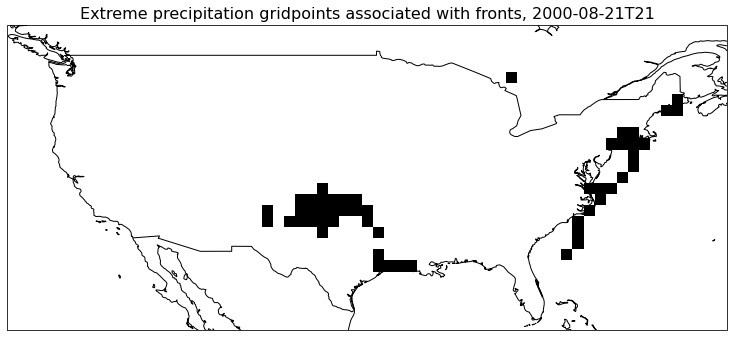

In [85]:
# gridpoints only (no precip info)

fig = plt.figure(figsize=(10,10))

#ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax = fig.add_axes([0.,0.,1.,1.], projection=ccrs.PlateCarree())

ax.coastlines()
ax.add_feature(cfeature.BORDERS)

# select time index
#t = '2000-07-05T12'
t = '2000-08-21T21'

pfield = (PEx_front.sel(time=t, lat=slice(26,50), lon=slice(-125,-68))[0]*1000*86400).notnull()
field, lon = add_cyclic_point(pfield, coord=pfield.lon)
lat = pfield.lat
c_prec = ax.pcolormesh(lon, lat, field, cmap='Greys', transform=ccrs.PlateCarree())
#ax.clabel(cf_prec, inline=1, fontsize=10)

# precip colorbar
#cbar_prec_ax = fig.add_axes([0.15, 0.25, 0.7, 0.02])
#cbar_prec = plt.colorbar(c_prec, cax=cbar_prec_ax, orientation='horizontal')
#cbar_prec.set_label('mm/day')

# add title
#ax.set_title('Precipitation, '+t, fontsize=16);
ax.set_title('Extreme precipitation gridpoints associated with fronts, '+t, fontsize=16);

#plt.savefig('../figures/toSCP/PEx_front_binary_CESM_2000-08-21-21.pdf', bbox_inches='tight')

### Percent gridpoints that overlap
Subsetting with `.sel()` earlier in the pipeline can help with optimization:
https://xarray.pydata.org/en/stable/user-guide/dask.html#chunking-and-performance

In [25]:
ngridpoints = PEx_front.lat.count() * PEx_front.lon.count()

In [26]:
# sanity check - should be 68*141
ngridpoints.values

array(9588)

In [15]:
overlap = PEx_front.notnull().sum(dim=('lat','lon'))

In [28]:
overlap

<xarray.DataArray 'PRECT' (time: 46719)>
dask.array<sum-aggregate, shape=(46719,), dtype=int64, chunksize=(360,), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 2000-01-01 03:00:00 ... 2015-12-31 21:00:00
    quantile  float64 0.9

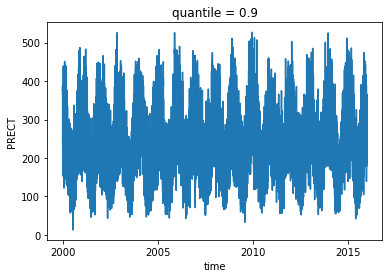

In [47]:
overlap.plot()

In [16]:
overlap_CONUS = PEx_front.sel(lat=slice(26,50), lon=slice(-125,-68)).notnull().sum(dim=('lat','lon'))

In [ ]:
overlap_CONUS

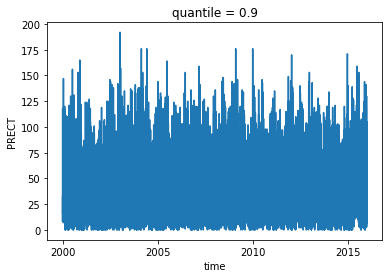

In [30]:
overlap_CONUS.plot()

In [31]:
%%time
noverlap = overlap.values

CPU times: user 20.4 s, sys: 547 ms, total: 20.9 s
Wall time: 25.2 s


In [32]:
npercent = 100*(noverlap/ngridpoints.values)
npercent

array([4.01543596, 4.03629537, 3.91113892, ..., 2.92031706, 2.77430121,
       2.25281602])

In [33]:
# sanity check - should be equal to number of time points
len(npercent)

46719

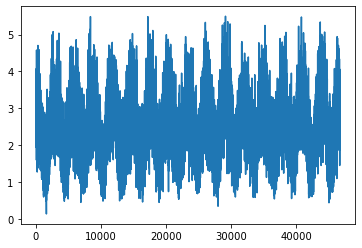

In [34]:
plt.plot(npercent);

In [35]:
# convert this back into a data array
npercent = xr.DataArray(npercent, dims=overlap.dims, coords=overlap.coords)
npercent

<xarray.DataArray (time: 46719)>
array([4.01543596, 4.03629537, 3.91113892, ..., 2.92031706, 2.77430121,
       2.25281602])
Coordinates:
  * time      (time) object 2000-01-01 03:00:00 ... 2015-12-31 21:00:00
    quantile  float64 0.9

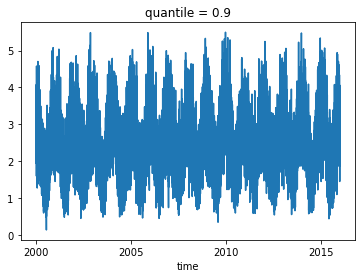

In [36]:
# plot with nicer time axis
npercent.plot();

### Percent gridpoints that overlap, relative to PEx gridpoints (instead of total)

In [17]:
PExgridpoints = PEx.notnull().sum(dim=('lat','lon'))

In [38]:
PExgridpoints

<xarray.DataArray 'PRECT' (time: 46719)>
dask.array<sum-aggregate, shape=(46719,), dtype=int64, chunksize=(600,), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 2000-01-01 03:00:00 ... 2015-12-31 21:00:00
    quantile  float64 0.9

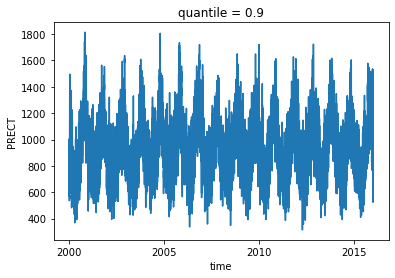

In [56]:
PExgridpoints.plot()

In [18]:
PExgridpoints_CONUS = PEx.sel(lat=slice(26,50), lon=slice(-125,-68)).notnull().sum(dim=('lat','lon'))

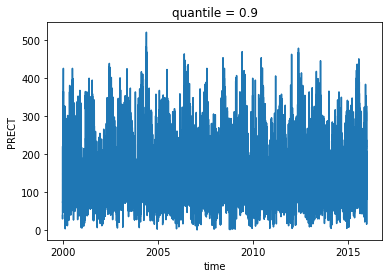

In [41]:
PExgridpoints_CONUS.plot()

In [19]:
npercentPEx = 100*(overlap/PExgridpoints)

In [43]:
npercentPEx

<xarray.DataArray 'PRECT' (time: 46719)>
dask.array<mul, shape=(46719,), dtype=float64, chunksize=(360,), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 2000-01-01 03:00:00 ... 2015-12-31 21:00:00
    quantile  float64 0.9

In [20]:
npercentPEx_CONUS = 100*(overlap_CONUS/PExgridpoints_CONUS)

In [45]:
npercentPEx_CONUS

<xarray.DataArray 'PRECT' (time: 46719)>
dask.array<mul, shape=(46719,), dtype=float64, chunksize=(360,), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 2000-01-01 03:00:00 ... 2015-12-31 21:00:00
    quantile  float64 0.9

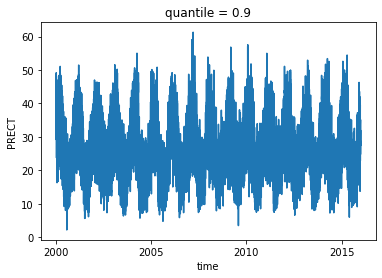

In [46]:
npercentPEx.plot();

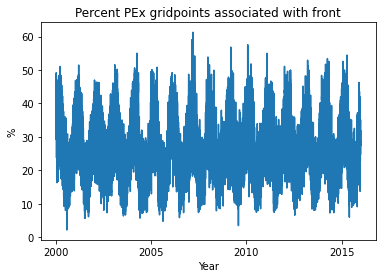

In [59]:
plt.plot(npercentPEx.time, npercentPEx)
plt.xlabel('Year')
plt.ylabel('%')
plt.title('Percent PEx gridpoints associated with front');
#plt.savefig('npercentPEx_2000-2005.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentPEx_2000-2015.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentPEx_2000-2015_3ha.png', bbox_inches='tight')

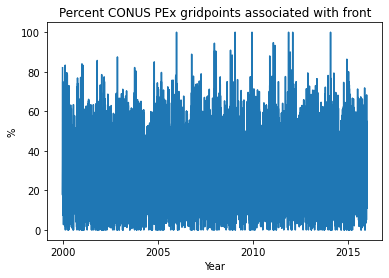

In [64]:
plt.plot(npercentPEx_CONUS.time, npercentPEx_CONUS)
plt.xlabel('Year')
plt.ylabel('%')
plt.title('Percent CONUS PEx gridpoints associated with front');
#plt.savefig('../figures/toSCP/npercentPEx_CONUS_2000-2015_3ha.png', bbox_inches='tight')

### Filter/groupby these timeseries plots to highlight average features

Try `.persist()` instead of `.load()` to prevent memory issues

In [65]:
# mean by time of day
npercentPEx_timeofday = npercentPEx.groupby("time.hour").mean().persist()

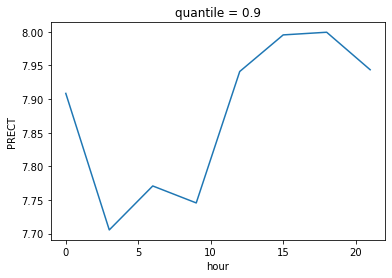

In [66]:
# standard deviation
npercentPEx_timeofday_std = npercentPEx.groupby("time.hour").std().persist()
npercentPEx_timeofday_std.plot()

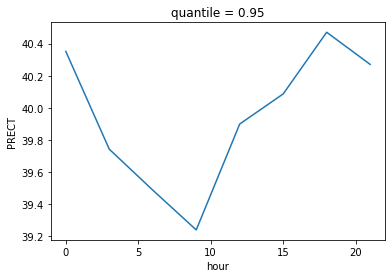

In [67]:
# 95th percentile (larger than standard dev.)
npercentPEx.chunk({'time': -1}).groupby("time.hour").quantile(0.95).plot()

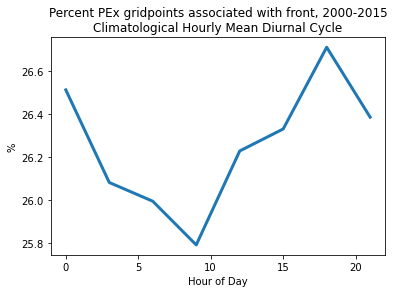

In [68]:
#npercentPEx.groupby("time.hour").mean().plot()

plt.plot(npercentPEx_timeofday.hour, npercentPEx_timeofday, linewidth=3)
plt.xlabel('Hour of Day')
plt.ylabel('%')
plt.title('Percent PEx gridpoints associated with front, 2000-2015\nClimatological Hourly Mean Diurnal Cycle');
#plt.savefig('../figures/toSCP/npercentPEx_timeofday_2000-2015.pdf', bbox_inches='tight')

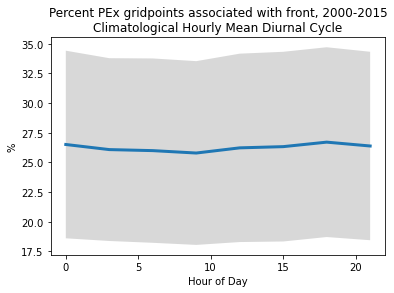

In [69]:
# with fill for standard deviation
plt.plot(npercentPEx_timeofday.hour, npercentPEx_timeofday, linewidth=3)
plt.fill_between(npercentPEx_timeofday.hour, npercentPEx_timeofday-npercentPEx_timeofday_std, 
                npercentPEx_timeofday+npercentPEx_timeofday_std, alpha=0.3, facecolor='grey')
plt.xlabel('Hour of Day')
plt.ylabel('%')
plt.title('Percent PEx gridpoints associated with front, 2000-2015\nClimatological Hourly Mean Diurnal Cycle');
#plt.savefig('../figures/toSCP/npercentPEx_timeofday_withstdev_2000-2015.pdf', bbox_inches='tight')

In [132]:
# mean by day of month
npercentPEx.groupby("time.day").mean()

<xarray.DataArray 'PRECT' (day: 31)>
dask.array<stack, shape=(31,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    quantile  float64 0.9
  * day       (day) int64 1 2 3 4 5 6 7 8 9 10 ... 22 23 24 25 26 27 28 29 30 31

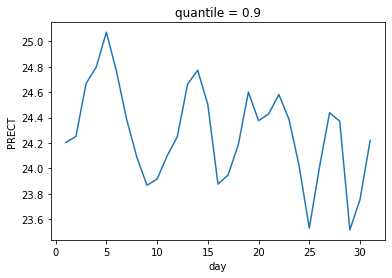

In [133]:
npercentPEx.groupby("time.day").mean().plot()

In [63]:
# mean by month of year
npercentPEx_monthofyear = npercentPEx.groupby("time.month").mean().persist()

In [71]:
# standard deviation
npercentPEx_monthofyear_std = npercentPEx.groupby("time.month").std().persist()

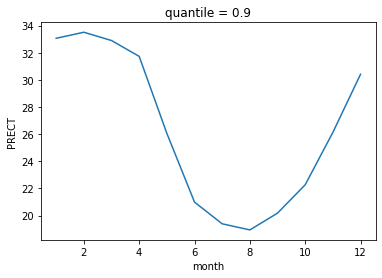

In [72]:
npercentPEx_monthofyear.plot()

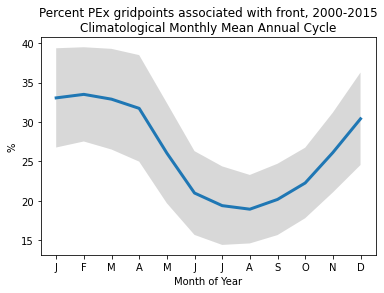

In [73]:
# with fill for standard deviation
plt.plot(npercentPEx_monthofyear.month, npercentPEx_monthofyear, linewidth=3)
plt.fill_between(npercentPEx_monthofyear.month, npercentPEx_monthofyear-npercentPEx_monthofyear_std, 
                npercentPEx_monthofyear+npercentPEx_monthofyear_std, alpha=0.3, facecolor='grey')
plt.xticks(np.arange(12)+1, ['J','F','M','A','M','J','J','A','S','O','N','D'])
plt.xlabel('Month of Year')
plt.ylabel('%')
plt.title('Percent PEx gridpoints associated with front, 2000-2015\nClimatological Monthly Mean Annual Cycle');
#plt.savefig('../figures/toSCP/npercentPEx_monthofyear_withstdev_2000-2015.pdf', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentPEx_monthofyear_withstdev_2000-2015_3ha.pdf', bbox_inches='tight')

In [138]:
# mean by day of year
npercentPEx_dayofyear = npercentPEx.groupby("time.dayofyear").mean().persist()

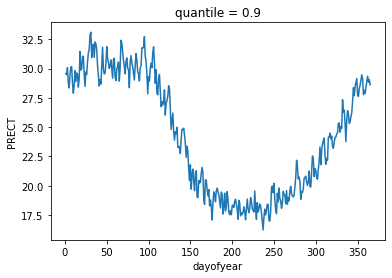

In [139]:
npercentPEx_dayofyear.plot()

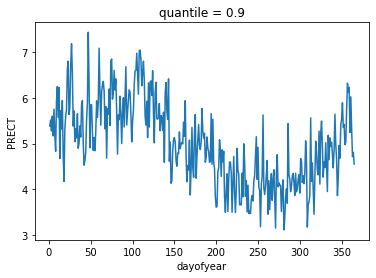

In [140]:
# standard deviation
npercentPEx_dayofyear_std = npercentPEx.groupby("time.dayofyear").std().persist()
npercentPEx_dayofyear_std.plot()

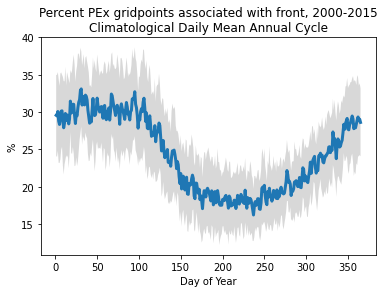

In [141]:
# with fill for standard deviation
plt.plot(npercentPEx_dayofyear.dayofyear, npercentPEx_dayofyear, linewidth=3)
plt.fill_between(npercentPEx_dayofyear.dayofyear, npercentPEx_dayofyear-npercentPEx_dayofyear_std, 
                npercentPEx_dayofyear+npercentPEx_dayofyear_std, alpha=0.3, facecolor='grey')
plt.xlabel('Day of Year')
plt.ylabel('%')
plt.title('Percent PEx gridpoints associated with front, 2000-2015\nClimatological Daily Mean Annual Cycle');
#plt.savefig('../figures/toSCP/npercentPEx_dayofyear_withstdev_2000-2015.pdf', bbox_inches='tight')

In [73]:
# CONUS mean by month of year
npercentPEx_monthofyear_CONUS = npercentPEx_CONUS.groupby("time.month").mean().persist()

In [131]:
# standard deviation
npercentPEx_monthofyear_std_CONUS = npercentPEx_CONUS.groupby("time.month").std().persist()

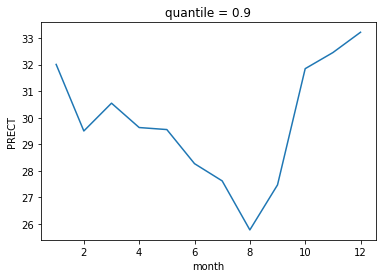

In [76]:
npercentPEx_monthofyear_CONUS.plot()

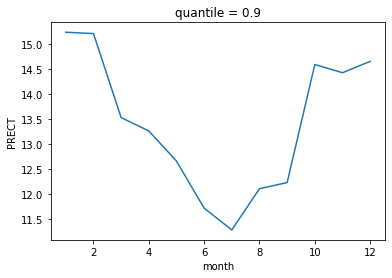

In [78]:
npercentPEx_monthofyear_std_CONUS.plot()

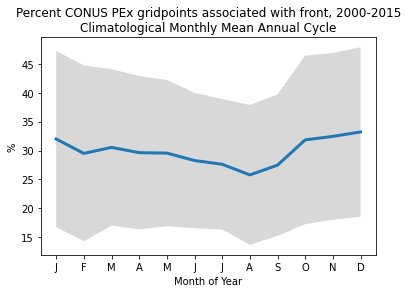

In [132]:
# with fill for standard deviation
plt.plot(npercentPEx_monthofyear_CONUS.month, npercentPEx_monthofyear_CONUS, linewidth=3)
plt.fill_between(npercentPEx_monthofyear_CONUS.month, npercentPEx_monthofyear_CONUS-npercentPEx_monthofyear_std_CONUS, 
                npercentPEx_monthofyear_CONUS+npercentPEx_monthofyear_std_CONUS, alpha=0.3, facecolor='grey')
plt.xticks(np.arange(12)+1, ['J','F','M','A','M','J','J','A','S','O','N','D'])
plt.xlabel('Month of Year')
plt.ylabel('%')
plt.title('Percent CONUS PEx gridpoints associated with front, 2000-2015\nClimatological Monthly Mean Annual Cycle');
#plt.savefig('../figures/toSCP/npercentPEx_monthofyear_CONUS_withstdev_2000-2015.pdf', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentPEx_monthofyear_CONUS_withstdev_2000-2015_3ha.pdf', bbox_inches='tight')

### Percent gridpoints that overlap, looking over time instead of space

In [21]:
# here need to calculate p90 as a timeseries instead of a spatial map. 90th percentile looking over space at each time point
p90_time = PRECT_1deg.chunk({'lat': -1, 'lon': -1}).quantile(0.9, dim=('lat','lon'))
p90_time

<xarray.DataArray 'PRECT' (time: 46719)>
dask.array<getitem, shape=(46719,), dtype=float64, chunksize=(600,), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 2000-01-01 03:00:00 ... 2015-12-31 21:00:00
    quantile  float64 0.9

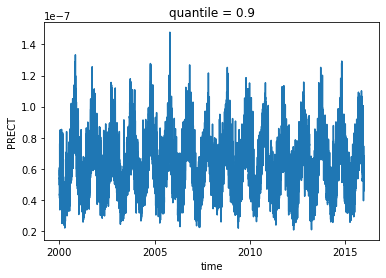

In [72]:
p90_time.plot()

In [22]:
PEx_time = PRECT_1deg.where(PRECT_1deg > p90_time)
PEx_time

,Array,Chunk
Bytes,3.34 GiB,0.92 MiB
Shape,"(46719, 68, 141)","(600, 10, 20)"
Count,13729 Tasks,4368 Chunks
Type,float64,numpy.ndarray


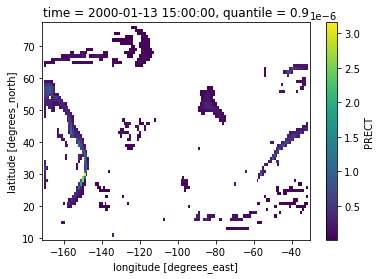

In [89]:
# compare to previous PEx (with p90 over time)
PEx.isel(time=100).plot()

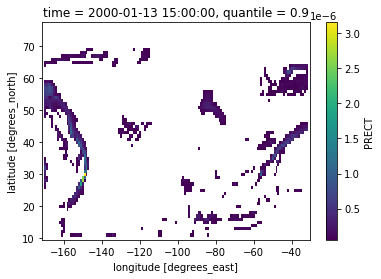

In [88]:
# different basis for "extreme" changes map slightly but not significantly
PEx_time.isel(time=100).plot()

In [23]:
PExgridpoints_time = PEx_time.notnull().sum(dim='time')
PExgridpoints_time

<xarray.DataArray 'PRECT' (lat: 68, lon: 141)>
dask.array<sum-aggregate, shape=(68, 141), dtype=int64, chunksize=(10, 20), chunktype=numpy.ndarray>
Coordinates:
  * lon       (lon) float64 -171.0 -170.0 -169.0 -168.0 ... -33.0 -32.0 -31.0
  * lat       (lat) float64 10.0 11.0 12.0 13.0 14.0 ... 74.0 75.0 76.0 77.0
    quantile  float64 0.9

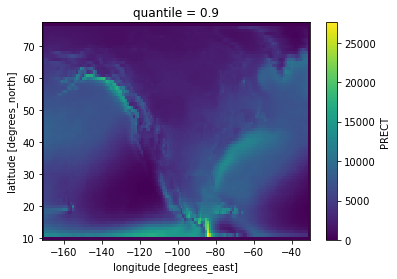

In [75]:
PExgridpoints_time.plot()

the old way (for reference)

In [55]:
# the old way
PExgridpoints_time = PEx.notnull().sum(dim='time')
PExgridpoints_time

<xarray.DataArray 'PRECT' (lat: 68, lon: 141)>
dask.array<sum-aggregate, shape=(68, 141), dtype=int64, chunksize=(10, 20), chunktype=numpy.ndarray>
Coordinates:
  * lon       (lon) float64 -171.0 -170.0 -169.0 -168.0 ... -33.0 -32.0 -31.0
  * lat       (lat) float64 10.0 11.0 12.0 13.0 14.0 ... 74.0 75.0 76.0 77.0
    quantile  float64 0.9

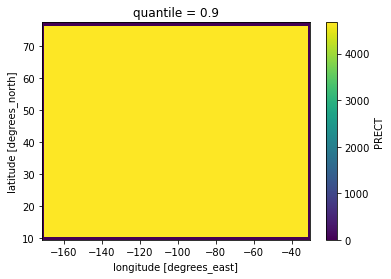

In [56]:
# this is constant over space...but should it be? 
# Should this be based on a PEx calculation which uses a quantile over space in stead of time?
PExgridpoints_time.plot()

In [67]:
# VERY difficult to figure out how to print the max value
np.nanmax(PExgridpoints_time)

4672

In [24]:
# redo PEx_front with PEx_time
PEx_front_time = PEx_time.where(anyfront.notnull())
PEx_front_time

,Array,Chunk
Bytes,3.34 GiB,562.50 kiB
Shape,"(46719, 68, 141)","(360, 10, 20)"
Count,65730 Tasks,10192 Chunks
Type,float64,numpy.ndarray


In [25]:
overlap_time = PEx_front_time.notnull().sum(dim='time')
overlap_time

<xarray.DataArray 'PRECT' (lat: 68, lon: 141)>
dask.array<sum-aggregate, shape=(68, 141), dtype=int64, chunksize=(10, 20), chunktype=numpy.ndarray>
Coordinates:
  * lon       (lon) float64 -171.0 -170.0 -169.0 -168.0 ... -33.0 -32.0 -31.0
  * lat       (lat) float64 10.0 11.0 12.0 13.0 14.0 ... 74.0 75.0 76.0 77.0
    quantile  float64 0.9

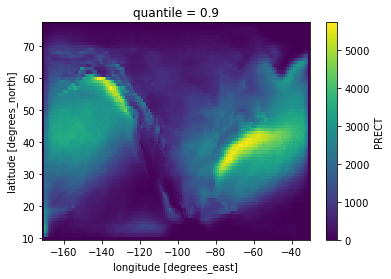

In [83]:
overlap_time.plot()

In [26]:
npercentPEx_time = 100*(overlap_time/PExgridpoints_time)
npercentPEx_time

<xarray.DataArray 'PRECT' (lat: 68, lon: 141)>
dask.array<mul, shape=(68, 141), dtype=float64, chunksize=(10, 20), chunktype=numpy.ndarray>
Coordinates:
  * lon       (lon) float64 -171.0 -170.0 -169.0 -168.0 ... -33.0 -32.0 -31.0
  * lat       (lat) float64 10.0 11.0 12.0 13.0 14.0 ... 74.0 75.0 76.0 77.0
    quantile  float64 0.9

CPU times: user 27.1 s, sys: 458 ms, total: 27.5 s
Wall time: 31.9 s


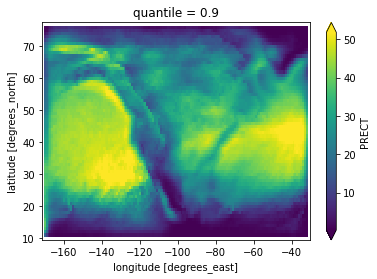

In [85]:
%%time
npercentPEx_time.plot(robust=True);

A nicer plot

In [86]:
# needed to determine number of values in discrete colormap
# since this is not greater than 60, don't necessarily need arrows at ends of colorbars
npercentPEx_time.max().values

array(59.12743972)

CPU times: user 35.3 s, sys: 668 ms, total: 36 s
Wall time: 45.9 s


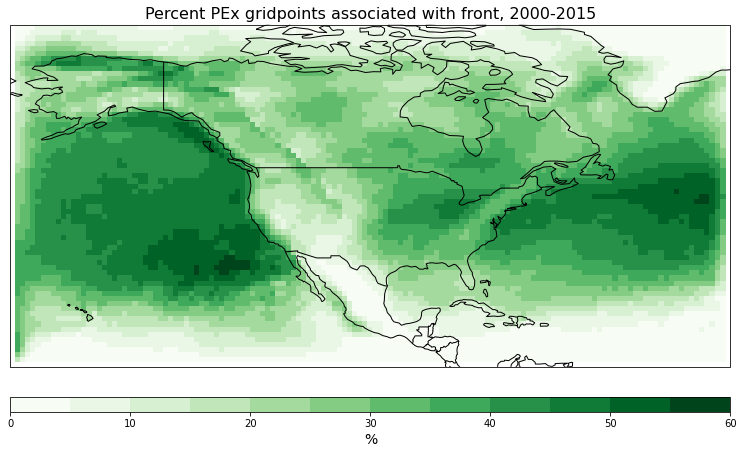

In [37]:
%%time
fig = plt.figure(figsize=(10,10))

#ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax = fig.add_axes([0.,0.,1.,1.], projection=ccrs.PlateCarree())

ax.coastlines()
ax.add_feature(cfeature.BORDERS)

# discrete colormap
cmap=plt.cm.get_cmap('Greens', 12)

field, lon = add_cyclic_point(npercentPEx_time, coord=npercentPEx_time.lon)
lat = npercentPEx_time.lat
#cf = ax.contourf(lon, lat, field, cmap='Greens', transform=ccrs.PlateCarree())
cf = ax.pcolor(lon, lat, field, vmin=0, vmax=60, cmap=cmap, transform=ccrs.PlateCarree())

# add colorbar
#cbar = plt.colorbar(cf, orientation='horizontal')
#cbar.set_label('%')
cb_ax = fig.add_axes([0, 0.2, 1, 0.02])
#norm = mpl.colors.Normalize(vmin=0, vmax=60)
cbar = plt.colorbar(cf, cax=cb_ax, orientation='horizontal')
cbar.ax.set_xlabel('%', fontsize=14)

# add title
#ax.set_title('Percent PEx gridpoints associated with front, 2000-2006', fontsize=16); # note this plot has a label error (should be 2000-2005)
ax.set_title('Percent PEx gridpoints associated with front, 2000-2015', fontsize=16); 

#plt.savefig('../figures/toSCP/npercentPEx_time_2000-2005.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentPEx_time_2000-2015.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentPEx_time_2000-2015_3ha.png', bbox_inches='tight')

### Modify for CONUS only
Redo this from the quantile calculation, since that looks over space, instead of cutting off the spatial region afterwards

In [27]:
p90_time_CONUS = PRECT_1deg.sel(lat=slice(26,50), lon=slice(-125,-68)).chunk({'lat': -1, 'lon': -1}).quantile(0.9, dim=('lat','lon'))
p90_time_CONUS

<xarray.DataArray 'PRECT' (time: 46719)>
dask.array<getitem, shape=(46719,), dtype=float64, chunksize=(600,), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 2000-01-01 03:00:00 ... 2015-12-31 21:00:00
    quantile  float64 0.9

In [28]:
PEx_time_CONUS = PRECT_1deg.sel(lat=slice(26,50), lon=slice(-125,-68)).where(PRECT_1deg.sel(lat=slice(26,50), lon=slice(-125,-68)) > p90_time_CONUS)
PEx_time_CONUS

,Array,Chunk
Bytes,516.83 MiB,0.92 MiB
Shape,"(46719, 25, 58)","(600, 10, 20)"
Count,8737 Tasks,1248 Chunks
Type,float64,numpy.ndarray


In [29]:
PExgridpoints_time_CONUS = PEx_time_CONUS.notnull().sum(dim='time')
PExgridpoints_time_CONUS

<xarray.DataArray 'PRECT' (lat: 25, lon: 58)>
dask.array<sum-aggregate, shape=(25, 58), dtype=int64, chunksize=(10, 20), chunktype=numpy.ndarray>
Coordinates:
  * lon       (lon) float64 -125.0 -124.0 -123.0 -122.0 ... -70.0 -69.0 -68.0
  * lat       (lat) float64 26.0 27.0 28.0 29.0 30.0 ... 47.0 48.0 49.0 50.0
    quantile  float64 0.9

In [30]:
PEx_front_time_CONUS = PEx_time_CONUS.where(anyfront.notnull())
PEx_front_time_CONUS

,Array,Chunk
Bytes,516.83 MiB,562.50 kiB
Shape,"(46719, 25, 58)","(360, 10, 20)"
Count,24598 Tasks,2912 Chunks
Type,float64,numpy.ndarray


In [31]:
overlap_time_CONUS = PEx_front_time_CONUS.notnull().sum(dim='time')
overlap_time_CONUS

<xarray.DataArray 'PRECT' (lat: 25, lon: 58)>
dask.array<sum-aggregate, shape=(25, 58), dtype=int64, chunksize=(10, 20), chunktype=numpy.ndarray>
Coordinates:
  * lat       (lat) float64 26.0 27.0 28.0 29.0 30.0 ... 47.0 48.0 49.0 50.0
  * lon       (lon) float64 -125.0 -124.0 -123.0 -122.0 ... -70.0 -69.0 -68.0
    quantile  float64 0.9

In [84]:
# the old way
npercentPEx_time_CONUS = npercentPEx_time.sel(lat=slice(26,50), lon=slice(-125,-68)) # CESM grid lons
npercentPEx_time_CONUS

<xarray.DataArray 'PRECT' (lat: 25, lon: 58)>
dask.array<getitem, shape=(25, 58), dtype=float64, chunksize=(10, 20), chunktype=numpy.ndarray>
Coordinates:
  * lon       (lon) float64 -125.0 -124.0 -123.0 -122.0 ... -70.0 -69.0 -68.0
  * lat       (lat) float64 26.0 27.0 28.0 29.0 30.0 ... 47.0 48.0 49.0 50.0
    quantile  float64 0.9

In [32]:
npercentPEx_time_CONUS = 100*(overlap_time_CONUS/PExgridpoints_time_CONUS)

In [44]:
# since this is not greater than 60, don't necessarily need arrows at ends of colorbars
npercentPEx_time_CONUS.max().values

array(50.4511895)

CPU times: user 15.5 s, sys: 434 ms, total: 15.9 s
Wall time: 25.8 s


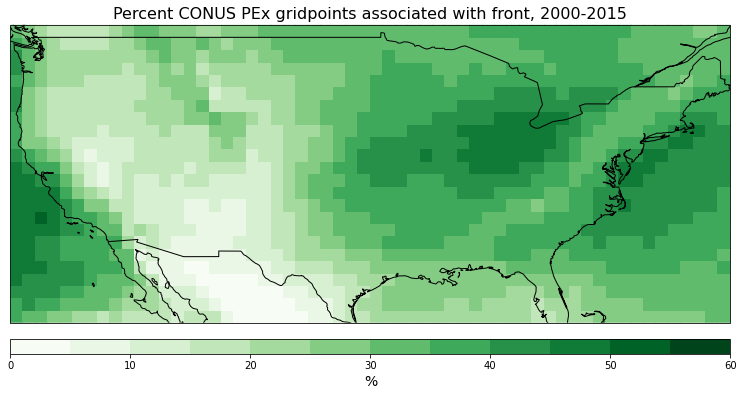

In [149]:
%%time
fig = plt.figure(figsize=(10,10))

#ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax = fig.add_axes([0.,0.,1.,1.], projection=ccrs.PlateCarree())

ax.coastlines()
ax.add_feature(cfeature.BORDERS)

# discrete colormap
cmap=plt.cm.get_cmap('Greens', 12)
#cmap=plt.cm.get_cmap('YlGn', 30)
#cmap=plt.cm.get_cmap('Blues', 20)

field, lon = add_cyclic_point(npercentPEx_time_CONUS, coord=npercentPEx_time_CONUS.lon)
lat = npercentPEx_time_CONUS.lat
#cf = ax.contourf(lon, lat, field, cmap='Greens', transform=ccrs.PlateCarree())
cf = ax.pcolor(lon, lat, field, cmap=cmap, vmin=0, vmax=60, transform=ccrs.PlateCarree())

# add colorbar
#cbar = plt.colorbar(cf, orientation='horizontal')
#cbar.set_label('%')
cb_ax = fig.add_axes([0, 0.25, 1, 0.02])
#norm = mpl.colors.Normalize(vmin=0, vmax=60)
cbar = plt.colorbar(cf, cax=cb_ax, orientation='horizontal')
cbar.ax.set_xlabel('%', fontsize=14)

# add title
ax.set_title('Percent CONUS PEx gridpoints associated with front, 2000-2015', fontsize=16); 

#plt.savefig('../figures/toSCP/npercentPEx_time_2000-2015.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentPEx_time_CONUS_2000-2015_3ha.png', bbox_inches='tight')

## CESM RCP8.5 simulation, 2086-2100

In [33]:
#onehot_file_rcp85 = "cesm_frontsOneHot_2086-2100.nc"
MN_file_rcp85 = "cesm_fronts_2086-2100_MaskedNetCDF_customgrid.nc"

In [34]:
#onehot_rcp85 = xr.open_dataset(cesm_fronts_filepath+onehot_file_rcp85, chunks={'time':360}) # aim for chunk size < 100mb
MN_rcp85 = xr.open_dataset(cesm_fronts_filepath+MN_file_rcp85, chunks={'time':360}) 

In [35]:
#fronts_rcp85 = onehot_rcp85.fronts
fronts_rcp85 = MN_rcp85.fronts

Extract most likely front from onehot (via argmax)

In [36]:
allfronts_rcp85 = fronts_rcp85.argmax(dim='front')

In [108]:
allfronts_rcp85

<xarray.DataArray 'fronts' (time: 43800, lat: 68, lon: 141)>
dask.array<nanarg_agg-aggregate, shape=(43800, 68, 141), dtype=int64, chunksize=(360, 68, 141), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2086-01-01 00:00:00 ... 2100-12-31 21:00:00
  * lon      (lon) float64 -171.0 -170.0 -169.0 -168.0 ... -33.0 -32.0 -31.0
  * lat      (lat) float64 10.0 11.0 12.0 13.0 14.0 ... 73.0 74.0 75.0 76.0 77.0

### Read in precipitation field

NOTE: If already processed, can skip to reading in regridded file below

In [91]:
cesm_rcp85_filepath = "/glade/campaign/cgd/ccr/kdagon/dlfront/BRCP85C5CN/" # RCP8.5 output

In [92]:
# h5.PRECT is 3hrly instantaneous
# h3.PRECT is 3hrly average
# remapped from unstructured grid to FV (still 1/4 degree so will not completely match frontal ID)

#PRECT_rcp85_files = "b.e13.BRCP85C5CN.ne120_g16.003a.cam.h5.PRECT*regrid*.nc"
PRECT_rcp85_files = "b.e13.BRCP85C5CN.ne120_g16.003a.cam.h3.PRECT*regrid*"

read in PRECT files with preprocessing function

In [93]:
%%time
PRECT_rcp85 = xr.open_mfdataset(cesm_rcp85_filepath+PRECT_rcp85_files, concat_dim='time', combine="nested", chunks={'time':150}, parallel=True, preprocess=preprocess)

CPU times: user 195 ms, sys: 9.08 ms, total: 204 ms
Wall time: 605 ms


In [94]:
PRECT_rcp85

<xarray.DataArray 'PRECT' (time: 43800, lat: 285, lon: 448)>
dask.array<concatenate, shape=(43800, 285, 448), dtype=float32, chunksize=(150, 285, 448), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 10.21 10.44 10.68 10.91 ... 76.15 76.39 76.62 76.86
  * lon      (lon) float64 189.1 189.4 189.7 190.0 ... 327.8 328.1 328.4 328.8
  * time     (time) object 2086-01-01 00:00:00 ... 2100-12-31 21:00:00
Attributes:
    units:          m/s
    long_name:      Total (convective and large-scale) precipitation rate (li...
    cell_methods:   time: mean
    cell_measures:  area: area

### Get rid of last time index (year 2101)
Only needed for 3hrly instantaneous output

In [95]:
#PRECT_rcp85 = PRECT_rcp85[:-1,:,:] # not sure how to do this with xarray indexing
#PRECT_rcp85

### Regridding precipitation output to match fronts

In [96]:
%%time
PRECT_1deg_rcp85_bil = regridder_bil(PRECT_rcp85)

CPU times: user 50.5 ms, sys: 2.97 ms, total: 53.5 ms
Wall time: 52 ms


/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


In [97]:
PRECT_1deg_rcp85_bil

<xarray.DataArray 'PRECT' (time: 43800, lat: 68, lon: 141)>
dask.array<transpose, shape=(43800, 68, 141), dtype=float64, chunksize=(150, 68, 141), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2086-01-01 00:00:00 ... 2100-12-31 21:00:00
  * lon      (lon) float64 -171.0 -170.0 -169.0 -168.0 ... -33.0 -32.0 -31.0
  * lat      (lat) float64 10.0 11.0 12.0 13.0 14.0 ... 73.0 74.0 75.0 76.0 77.0
Attributes:
    regrid_method:  bilinear

### Save out regional, concatenated, regridded file to prevent Dask memory issues

In [98]:
#PRECT_1deg_rcp85_bil.to_netcdf(postprocessing_filepath+'PRECT_NA_rcp85_1deg_bil.nc', mode='w', format='NETCDF4')
PRECT_1deg_rcp85_bil.to_netcdf(postprocessing_filepath+'PRECT_3hravg_NA_rcp85_1deg_bil.nc', mode='w', format='NETCDF4')

### Read back in intermediate file

This time, include lat/lon chunks to help with quantile calculation

In [37]:
#PRECT_1deg_rcp85 = xr.open_dataarray(postprocessing_filepath+'PRECT_NA_rcp85_1deg_bil.nc', chunks={'time':600, 'lat':10, 'lon':20})
PRECT_1deg_rcp85 = xr.open_dataarray(postprocessing_filepath+'PRECT_3hravg_NA_rcp85_1deg_bil.nc', chunks={'time':600, 'lat':10, 'lon':20})
PRECT_1deg_rcp85

,Array,Chunk
Bytes,3.13 GiB,0.92 MiB
Shape,"(43800, 68, 141)","(600, 10, 20)"
Count,4089 Tasks,4088 Chunks
Type,float64,numpy.ndarray


### Calculate 90th percentile precipitation at each gridpoint

In [38]:
p90_rcp85 = PRECT_1deg_rcp85.chunk({'time': -1}).quantile(0.9, dim='time')

### Select gridpoints where precipitation at a given time is greater than p90

In [39]:
PEx_rcp85 = PRECT_1deg_rcp85.where(PRECT_1deg_rcp85 > p90_rcp85)

CPU times: user 3.34 s, sys: 111 ms, total: 3.45 s
Wall time: 6.42 s


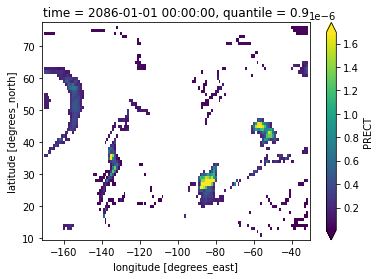

In [102]:
%%time
PEx_rcp85.isel(time=0).plot(robust=True);

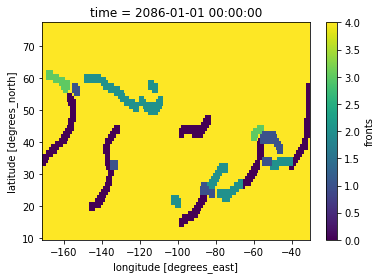

In [103]:
# fronts at the same time index
allfronts_rcp85.isel(time=0).plot();

### Make a front mask (any/none)

In [40]:
anyfront_rcp85 = allfronts_rcp85.where(allfronts_rcp85 < 4)

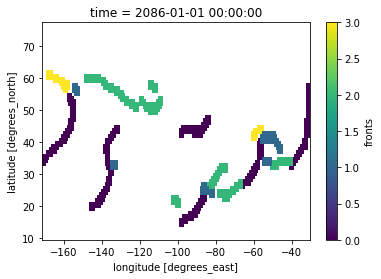

In [105]:
anyfront_rcp85.isel(time=0).plot();

### Find gridpoints that overlap (front & PEx)

In [41]:
PEx_front_rcp85 = PEx_rcp85.where(anyfront_rcp85.notnull())

In [114]:
PEx_front_rcp85

,Array,Chunk
Bytes,3.13 GiB,562.50 kiB
Shape,"(43800, 68, 141)","(360, 10, 20)"
Count,61290 Tasks,9520 Chunks
Type,float64,numpy.ndarray


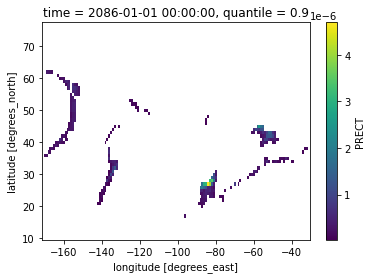

In [115]:
# PEx associated with fronts (overlapping gridpoints)
PEx_front_rcp85.isel(time=0).plot();

### Percent gridpoints that overlap, relative to PEx gridpoints (instead of total)

In [42]:
overlap_rcp85 = PEx_front_rcp85.notnull().sum(dim=('lat','lon'))

In [43]:
overlap_rcp85_CONUS = PEx_front_rcp85.sel(lat=slice(26,50), lon=slice(-125,-68)).notnull().sum(dim=('lat','lon'))

In [44]:
PExgridpoints_rcp85 = PEx_rcp85.notnull().sum(dim=('lat','lon'))

In [45]:
PExgridpoints_rcp85_CONUS = PEx_rcp85.sel(lat=slice(26,50), lon=slice(-125,-68)).notnull().sum(dim=('lat','lon'))

In [46]:
npercentPEx_rcp85 = 100*(overlap_rcp85/PExgridpoints_rcp85)
npercentPEx_rcp85_CONUS = 100*(overlap_rcp85_CONUS/PExgridpoints_rcp85_CONUS)

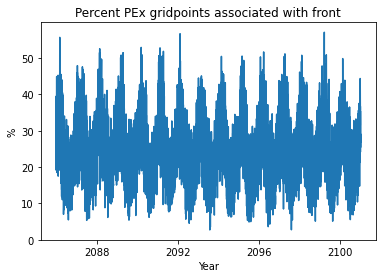

In [121]:
plt.plot(npercentPEx_rcp85.time, npercentPEx_rcp85)
plt.xlabel('Year')
plt.ylabel('%')
plt.title('Percent PEx gridpoints associated with front');
#plt.savefig('../figures/toSCP/npercentPEx_2086-2100.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentPEx_2086-2100_3ha.png', bbox_inches='tight')

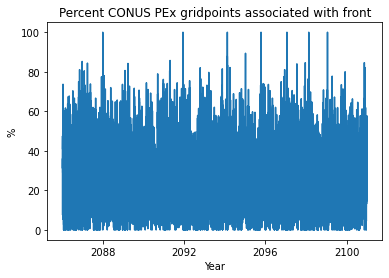

In [127]:
plt.plot(npercentPEx_rcp85_CONUS.time, npercentPEx_rcp85_CONUS)
plt.xlabel('Year')
plt.ylabel('%')
plt.title('Percent CONUS PEx gridpoints associated with front');
#plt.savefig('../figures/toSCP/npercentPEx_CONUS_2086-2100_3ha.png', bbox_inches='tight')

In [61]:
# mean by month of year
npercentPEx_rcp85_monthofyear = npercentPEx_rcp85.groupby("time.month").mean().persist()

In [117]:
# standard deviation
npercentPEx_rcp85_monthofyear_std = npercentPEx_rcp85.groupby("time.month").std().persist()

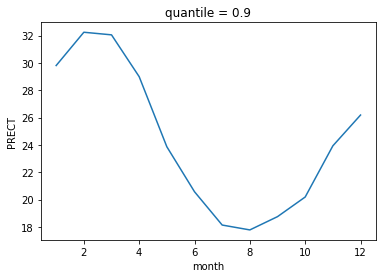

In [118]:
npercentPEx_rcp85_monthofyear.plot()

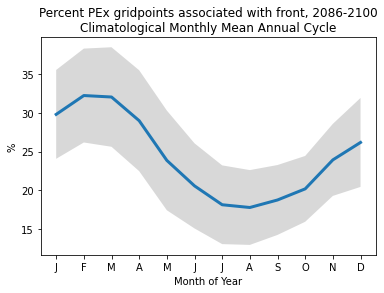

In [119]:
# with fill for standard deviation
plt.plot(npercentPEx_rcp85_monthofyear.month, npercentPEx_rcp85_monthofyear, linewidth=3)
plt.fill_between(npercentPEx_rcp85_monthofyear.month, npercentPEx_rcp85_monthofyear-npercentPEx_rcp85_monthofyear_std, 
                npercentPEx_rcp85_monthofyear+npercentPEx_rcp85_monthofyear_std, alpha=0.3, facecolor='grey')
plt.xticks(np.arange(12)+1, ['J','F','M','A','M','J','J','A','S','O','N','D'])
plt.xlabel('Month of Year')
plt.ylabel('%')
plt.title('Percent PEx gridpoints associated with front, 2086-2100\nClimatological Monthly Mean Annual Cycle');
#plt.savefig('../figures/toSCP/npercentPEx_monthofyear_withstdev_2086-2100.pdf', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentPEx_monthofyear_withstdev_2086-2100_3ha.pdf', bbox_inches='tight')

In [72]:
npercentPEx_rcp85_monthofyear_CONUS = npercentPEx_rcp85_CONUS.groupby("time.month").mean().persist()

In [125]:
npercentPEx_rcp85_monthofyear_std_CONUS = npercentPEx_rcp85_CONUS.groupby("time.month").std().persist()

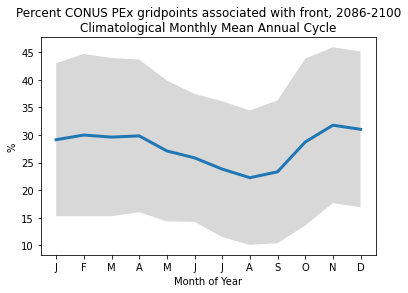

In [126]:
plt.plot(npercentPEx_rcp85_monthofyear_CONUS.month, npercentPEx_rcp85_monthofyear_CONUS, linewidth=3)
plt.fill_between(npercentPEx_rcp85_monthofyear_CONUS.month, npercentPEx_rcp85_monthofyear_CONUS-npercentPEx_rcp85_monthofyear_std_CONUS, 
                npercentPEx_rcp85_monthofyear_CONUS+npercentPEx_rcp85_monthofyear_std_CONUS, alpha=0.3, facecolor='grey')
plt.xticks(np.arange(12)+1, ['J','F','M','A','M','J','J','A','S','O','N','D'])
plt.xlabel('Month of Year')
plt.ylabel('%')
plt.title('Percent CONUS PEx gridpoints associated with front, 2086-2100\nClimatological Monthly Mean Annual Cycle');
#plt.savefig('../figures/toSCP/npercentPEx_monthofyear_CONUS_withstdev_2086-2100_3ha.pdf', bbox_inches='tight')

### Percent gridpoints that overlap, looking over time instead of space

In [47]:
p90_rcp85_time = PRECT_1deg_rcp85.chunk({'lat': -1, 'lon': -1}).quantile(0.9, dim=('lat','lon'))
PEx_rcp85_time = PRECT_1deg_rcp85.where(PRECT_1deg_rcp85 > p90_rcp85_time)
PExgridpoints_rcp85_time = PEx_rcp85_time.notnull().sum(dim='time')
PEx_front_rcp85_time = PEx_rcp85_time.where(anyfront_rcp85.notnull())
overlap_rcp85_time = PEx_front_rcp85_time.notnull().sum(dim='time')
npercentPEx_rcp85_time = 100*(overlap_rcp85_time/PExgridpoints_rcp85_time)

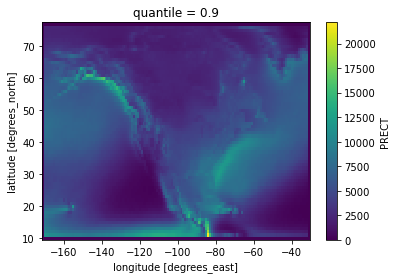

In [143]:
PExgridpoints_rcp85_time.plot()

In [48]:
p90_rcp85_time_CONUS = PRECT_1deg_rcp85.sel(lat=slice(26,50), lon=slice(-125,-68)).chunk({'lat': -1, 'lon': -1}).quantile(0.9, dim=('lat','lon'))
PEx_rcp85_time_CONUS = PRECT_1deg_rcp85.sel(lat=slice(26,50), lon=slice(-125,-68)).where(PRECT_1deg_rcp85.sel(lat=slice(26,50), lon=slice(-125,-68)) > p90_rcp85_time_CONUS)
PExgridpoints_rcp85_time_CONUS = PEx_rcp85_time_CONUS.notnull().sum(dim='time')
PEx_front_rcp85_time_CONUS = PEx_rcp85_time_CONUS.where(anyfront_rcp85.notnull())
overlap_rcp85_time_CONUS = PEx_front_rcp85_time_CONUS.notnull().sum(dim='time')
npercentPEx_rcp85_time_CONUS = 100*(overlap_rcp85_time_CONUS/PExgridpoints_rcp85_time_CONUS)

In [74]:
# since this is not greater than 60, don't necessarily need arrows at ends of colorbars
npercentPEx_rcp85_time.max().values

array(59.28143713)

/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1887: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)


CPU times: user 35.6 s, sys: 649 ms, total: 36.2 s
Wall time: 48.1 s


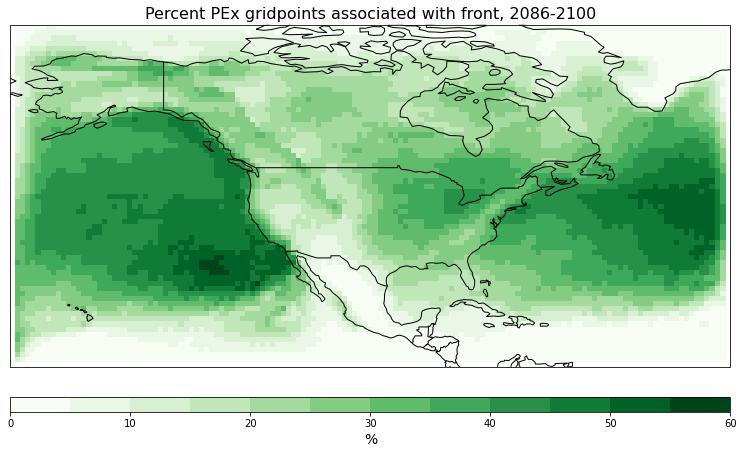

In [61]:
%%time
fig = plt.figure(figsize=(10,10))

ax = fig.add_axes([0.,0.,1.,1.], projection=ccrs.PlateCarree())

ax.coastlines()
ax.add_feature(cfeature.BORDERS)

# discrete colormap
cmap=plt.cm.get_cmap('Greens', 12)

field, lon = add_cyclic_point(npercentPEx_rcp85_time, coord=npercentPEx_rcp85_time.lon)
lat = npercentPEx_rcp85_time.lat
cf = ax.pcolor(lon, lat, field, vmin=0, vmax=60, cmap=cmap, transform=ccrs.PlateCarree())

# add colorbar
#cbar = plt.colorbar(cf, orientation='horizontal')
#cbar.set_label('%')
cb_ax = fig.add_axes([0, 0.2, 1, 0.02])
cbar = plt.colorbar(cf, cax=cb_ax, orientation='horizontal')
cbar.ax.set_xlabel('%', fontsize=14)

# add title
ax.set_title('Percent PEx gridpoints associated with front, 2086-2100', fontsize=16); 

#plt.savefig('../figures/toSCP/npercentPEx_time_2085-2100.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentPEx_time_CONUS_2085-2100_3ha.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentPEx_time_2085-2100_3ha.png', bbox_inches='tight')

In [73]:
# since this is not greater than 60, don't necessarily need arrows at ends of colorbars
npercentPEx_rcp85_time_CONUS.max().values

array(50.89766607)

CPU times: user 13.4 s, sys: 334 ms, total: 13.7 s
Wall time: 22 s


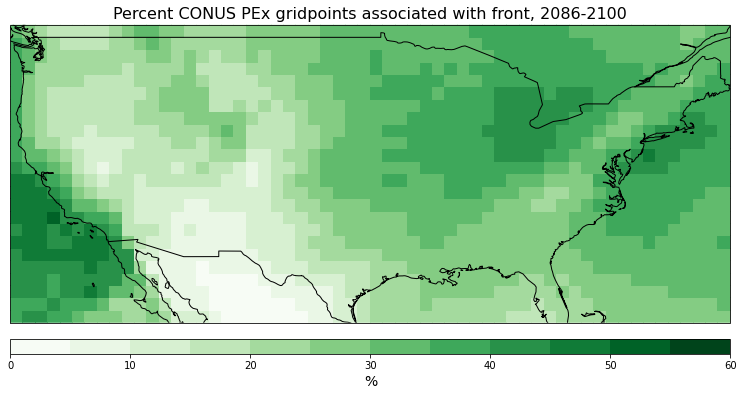

In [62]:
%%time
fig = plt.figure(figsize=(10,10))

ax = fig.add_axes([0.,0.,1.,1.], projection=ccrs.PlateCarree())

ax.coastlines()
ax.add_feature(cfeature.BORDERS)

# discrete colormap
cmap=plt.cm.get_cmap('Greens', 12)

field, lon = add_cyclic_point(npercentPEx_rcp85_time_CONUS, coord=npercentPEx_rcp85_time_CONUS.lon)
lat = npercentPEx_rcp85_time_CONUS.lat
cf = ax.pcolor(lon, lat, field, vmin=0, vmax=60, cmap=cmap, transform=ccrs.PlateCarree())

# add colorbar
#cbar = plt.colorbar(cf, orientation='horizontal')
#cbar.set_label('%')
cb_ax = fig.add_axes([0, 0.25, 1, 0.02])
cbar = plt.colorbar(cf, cax=cb_ax, orientation='horizontal')
cbar.ax.set_xlabel('%', fontsize=14)

# add title
ax.set_title('Percent CONUS PEx gridpoints associated with front, 2086-2100', fontsize=16); 

#plt.savefig('../figures/toSCP/npercentPEx_time_CONUS_2086-2100_3ha.png', bbox_inches='tight')

## Difference, RCP8.5 - historical/RCP2.6

### Subset historical to match # years (2000-2014)

In [150]:
npercentPEx

<xarray.DataArray 'PRECT' (time: 46719)>
dask.array<mul, shape=(46719,), dtype=float64, chunksize=(360,), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 2000-01-01 03:00:00 ... 2015-12-31 21:00:00
    quantile  float64 0.9

In [49]:
#npercentPEx.sel(time="2000-01-01 03:00:00")
#npercentPEx.sel(time="2014-12-31 21:00:00")
#npercentPEx.sel(time=slice("2000-01-01 03:00:00", "2014-12-31 21:00:00")) # this does not work for reasons I don't understand?
npercentPEx_subset = npercentPEx[:43800] # so I have to do it the old fashioned way (just cut off the last year manually)
npercentPEx_subset

<xarray.DataArray 'PRECT' (time: 43800)>
dask.array<getitem, shape=(43800,), dtype=float64, chunksize=(360,), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 2000-01-01 03:00:00 ... 2015-01-01 00:00:00
    quantile  float64 0.9

In [152]:
npercentPEx_rcp85

<xarray.DataArray 'PRECT' (time: 43800)>
dask.array<mul, shape=(43800,), dtype=float64, chunksize=(360,), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 2086-01-01 00:00:00 ... 2100-12-31 21:00:00
    quantile  float64 0.9

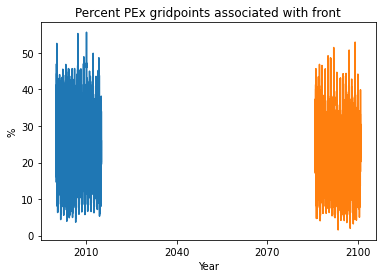

In [163]:
plt.plot(npercentPEx_subset.time, npercentPEx_subset)
plt.plot(npercentPEx_rcp85.time, npercentPEx_rcp85)
plt.xlabel('Year')
plt.ylabel('%')
plt.title('Percent PEx gridpoints associated with front');

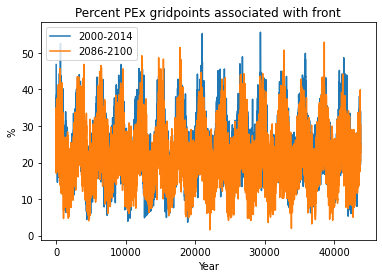

In [172]:
plt.plot(npercentPEx_subset, label='2000-2014')
plt.plot(npercentPEx_rcp85, label='2086-2100')
plt.xlabel('Time')
plt.ylabel('%')
plt.title('Percent PEx gridpoints associated with front')
plt.legend();

In [84]:
# difference in PEx gridpoints (without fronts)
PExgridpoints_subset = PExgridpoints[:43800]
PExgridpoints_diff = PExgridpoints_rcp85 - PExgridpoints_subset
PExgridpoints_diff
# the above will result in a zero array because of the time index mismatch
# TO DO: figure out how to calculate the difference in a meaningful way to see how PEx is changing (without fronts)

<xarray.DataArray 'PRECT' (time: 0)>
dask.array<sub, shape=(0,), dtype=int64, chunksize=(0,), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 
    quantile  float64 0.9

In [87]:
# can calculate climatological monthly mean and then difference that
# technically historical has one more year going into the climatological mean
PExgridpoints_monthofyear = PExgridpoints.groupby("time.month").mean().persist()
PExgridpoints_rcp85_monthofyear = PExgridpoints_rcp85.groupby("time.month").mean().persist()

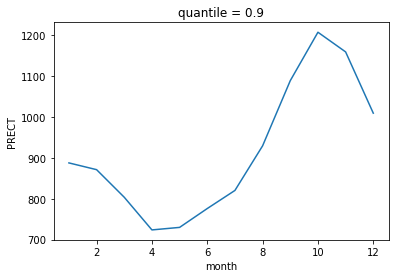

In [54]:
PExgridpoints_monthofyear.plot()

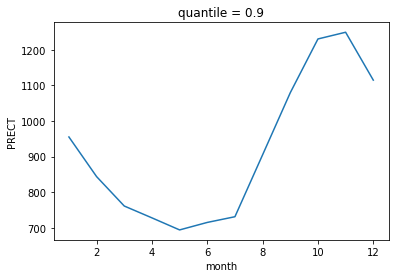

In [55]:
PExgridpoints_rcp85_monthofyear.plot()

In [57]:
# monthly mean diff: PExgridpoints
PExgridpoints_monthlydiff = PExgridpoints_rcp85_monthofyear - PExgridpoints_monthofyear
PExgridpoints_monthlyperdiff = 100*(PExgridpoints_monthlydiff/PExgridpoints_monthofyear)
PExgridpoints_monthlyperdiff

<xarray.DataArray 'PRECT' (month: 12)>
dask.array<mul, shape=(12,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    quantile  float64 0.9
  * month     (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

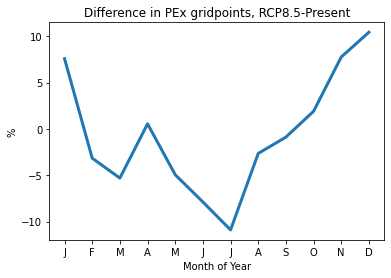

In [69]:
plt.plot(PExgridpoints_monthlyperdiff.month, PExgridpoints_monthlyperdiff, linewidth=3)
plt.xticks(np.arange(12)+1, ['J','F','M','A','M','J','J','A','S','O','N','D'])
plt.xlabel('Month of Year')
plt.ylabel('%')
plt.title('Difference in PEx gridpoints, RCP8.5-Present');
#plt.savefig('../figures/toSCP/PEx_monthofyear_perdiff_3ha.png', bbox_inches='tight')

In [89]:
# again, technically historical has one more year going into the climatological mean
PExgridpoints_CONUS_monthofyear = PExgridpoints_CONUS.groupby("time.month").mean().persist()
PExgridpoints_rcp85_CONUS_monthofyear = PExgridpoints_rcp85_CONUS.groupby("time.month").mean().persist()

In [90]:
PExgridpoints_CONUS_monthlydiff = PExgridpoints_rcp85_CONUS_monthofyear - PExgridpoints_CONUS_monthofyear
PExgridpoints_CONUS_monthlyperdiff = 100*(PExgridpoints_CONUS_monthlydiff/PExgridpoints_CONUS_monthofyear)
PExgridpoints_CONUS_monthlyperdiff

<xarray.DataArray 'PRECT' (month: 12)>
dask.array<mul, shape=(12,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    quantile  float64 0.9
  * month     (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

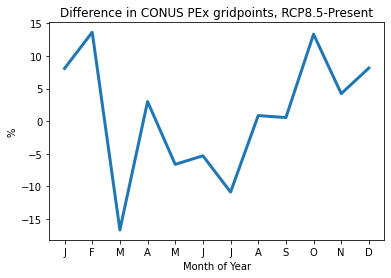

In [92]:
plt.plot(PExgridpoints_CONUS_monthlyperdiff.month, PExgridpoints_CONUS_monthlyperdiff, linewidth=3)
plt.xticks(np.arange(12)+1, ['J','F','M','A','M','J','J','A','S','O','N','D'])
plt.xlabel('Month of Year')
plt.ylabel('%')
plt.title('Difference in CONUS PEx gridpoints, RCP8.5-Present');
#plt.savefig('../figures/toSCP/PEx_monthofyear_CONUS_perdiff_3ha.png', bbox_inches='tight')

In [95]:
# annual mean over CONUS
PExgridpoints_CONUS_monthlyperdiff.mean().values

array(1.02372283)

In [64]:
# monthly mean diff: npercentPEx
monthlydiff = npercentPEx_rcp85_monthofyear - npercentPEx_monthofyear
monthlydiff

<xarray.DataArray 'PRECT' (month: 12)>
dask.array<sub, shape=(12,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    quantile  float64 0.9
  * month     (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

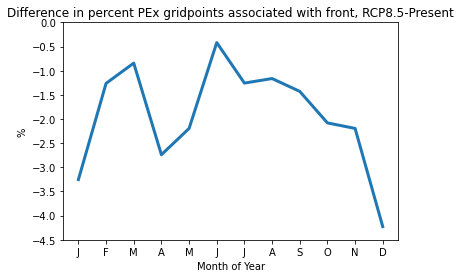

In [70]:
plt.plot(monthlydiff.month, monthlydiff, linewidth=3)
#plt.fill_between(npercentPEx_rcp85_monthofyear.month, npercentPEx_rcp85_monthofyear-npercentPEx_rcp85_monthofyear_std, 
#                npercentPEx_rcp85_monthofyear+npercentPEx_rcp85_monthofyear_std, alpha=0.3, facecolor='grey')
plt.xticks(np.arange(12)+1, ['J','F','M','A','M','J','J','A','S','O','N','D'])
plt.xlabel('Month of Year')
plt.ylabel('%')
plt.ylim(-4.5,0)
plt.title('Difference in percent PEx gridpoints associated with front, RCP8.5-Present');
#plt.savefig('../figures/toSCP/npercentPEx_monthofyear_diff.pdf', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentPEx_monthofyear_diff_3ha.png', bbox_inches='tight')

In [74]:
# CONUS diff
monthlydiff_CONUS = npercentPEx_rcp85_monthofyear_CONUS - npercentPEx_monthofyear_CONUS

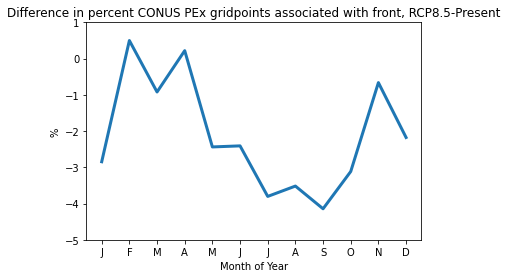

In [78]:
plt.plot(monthlydiff_CONUS.month, monthlydiff_CONUS, linewidth=3)
plt.xticks(np.arange(12)+1, ['J','F','M','A','M','J','J','A','S','O','N','D'])
plt.xlabel('Month of Year')
plt.ylabel('%')
plt.ylim(-5,1)
plt.title('Difference in percent CONUS PEx gridpoints associated with front, RCP8.5-Present');
#plt.savefig('../figures/toSCP/npercentPEx_monthofyear_CONUS_diff_3ha.png', bbox_inches='tight')

In [63]:
spatialdiff = npercentPEx_rcp85_time - npercentPEx_time
spatialdiff_CONUS = npercentPEx_rcp85_time_CONUS - npercentPEx_time_CONUS

CPU times: user 1min, sys: 1.26 s, total: 1min 1s
Wall time: 1min 10s


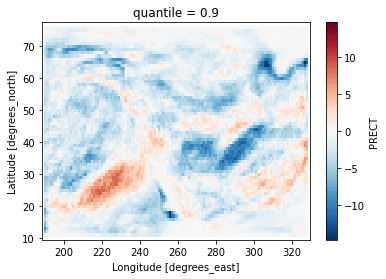

In [175]:
%%time
spatialdiff.plot();

Finding bounds for colorbar

In [65]:
spatialdiff.max().values

array(22.45833243)

In [66]:
spatialdiff.min().values

array(-21.21930464)

CPU times: user 29.2 s, sys: 641 ms, total: 29.9 s
Wall time: 46.4 s


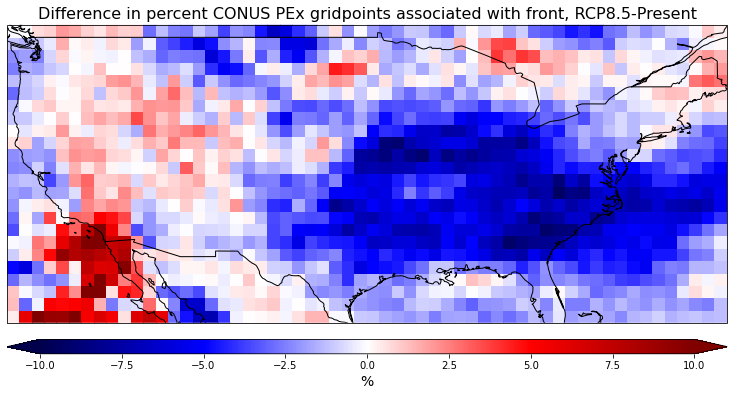

In [69]:
%%time
fig = plt.figure(figsize=(10,10))

#ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax = fig.add_axes([0.,0.,1.,1.], projection=ccrs.PlateCarree())

ax.coastlines()
ax.add_feature(cfeature.BORDERS)

# discrete colormap
#cmap=plt.cm.get_cmap('seismic', 48)
cmap=plt.cm.get_cmap('seismic')

# CONUS
field, lon = add_cyclic_point(spatialdiff_CONUS, coord=spatialdiff_CONUS.lon)
lat = spatialdiff_CONUS.lat
cf = ax.pcolor(lon, lat, field, cmap=cmap, vmin=-10, vmax=10, transform=ccrs.PlateCarree())

# whole field
#field, lon = add_cyclic_point(spatialdiff, coord=spatialdiff.lon)
#lat = spatialdiff.lat
#cf = ax.pcolor(lon, lat, field, cmap=cmap, vmin=-20, vmax=20, transform=ccrs.PlateCarree())

# add colorbar
#cbar = plt.colorbar(cf, orientation='horizontal')
#cbar.set_label('%')

# CONUS placement
cb_ax = fig.add_axes([0, 0.25, 1, 0.02])

# whole field placement
#cb_ax = fig.add_axes([0, 0.2, 1, 0.02])

cbar = plt.colorbar(cf, cax=cb_ax, orientation='horizontal', extend='both')
cbar.ax.set_xlabel('%', fontsize=14)

# add title
#ax.set_title('Difference in percent PEx gridpoints associated with front, RCP8.5-Present', fontsize=16); 
ax.set_title('Difference in percent CONUS PEx gridpoints associated with front, RCP8.5-Present', fontsize=16); 

#plt.savefig('../figures/toSCP/npercentPEx_time_diff_altcolor.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentPEx_time_CONUS_diff_altcolor_3ha.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentPEx_time_diff_3ha.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentPEx_time_CONUS_diff_3ha.png', bbox_inches='tight')

### Difference in PEx grid(time)points (separate from fronts)

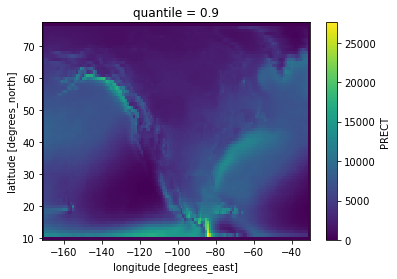

In [165]:
PExgridpoints_time.plot()

In [96]:
spatialdiff_PEx = PExgridpoints_rcp85_time - PExgridpoints_time

In [168]:
spatialdiff_PEx

<xarray.DataArray 'PRECT' (lat: 68, lon: 141)>
dask.array<sub, shape=(68, 141), dtype=int64, chunksize=(10, 20), chunktype=numpy.ndarray>
Coordinates:
  * lon       (lon) float64 -171.0 -170.0 -169.0 -168.0 ... -33.0 -32.0 -31.0
  * lat       (lat) float64 10.0 11.0 12.0 13.0 14.0 ... 74.0 75.0 76.0 77.0
    quantile  float64 0.9

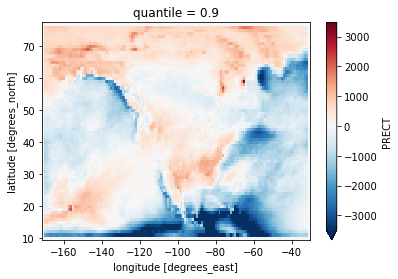

In [174]:
spatialdiff_PEx.plot(robust=True)

Percent difference

In [71]:
spatialperdiff_PEx = 100*(PExgridpoints_rcp85_time - PExgridpoints_time)/PExgridpoints_time

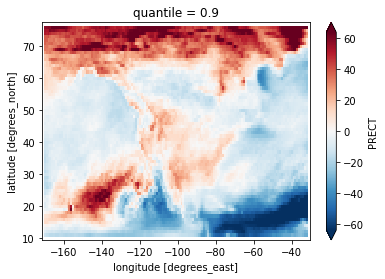

In [177]:
spatialperdiff_PEx.plot(robust=True)

Try difference in percent PEx gridpoints instead of difference in total PEx gridpoints

In [170]:
ngridpoints = 68*141
ngridpoints

9588

In [171]:
PExgridpoints_time

<xarray.DataArray 'PRECT' (lat: 68, lon: 141)>
dask.array<sum-aggregate, shape=(68, 141), dtype=int64, chunksize=(10, 20), chunktype=numpy.ndarray>
Coordinates:
  * lon       (lon) float64 -171.0 -170.0 -169.0 -168.0 ... -33.0 -32.0 -31.0
  * lat       (lat) float64 10.0 11.0 12.0 13.0 14.0 ... 74.0 75.0 76.0 77.0
    quantile  float64 0.9

TypeError: unsupported operand type(s) for *: 'int' and 'QuadMesh'

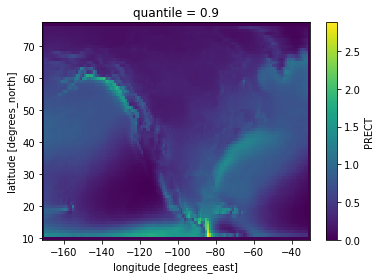

In [172]:
100*(PExgridpoints_time/ngridpoints).plot()

/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1887: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)


CPU times: user 24.8 s, sys: 522 ms, total: 25.3 s
Wall time: 40.9 s


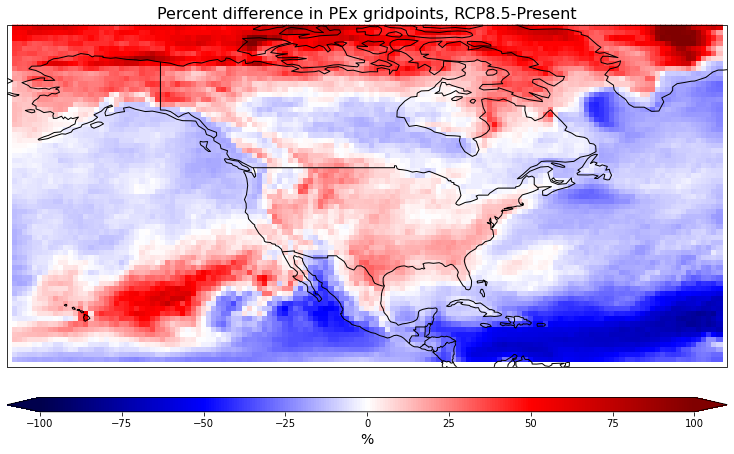

In [72]:
%%time
fig = plt.figure(figsize=(10,10))

#ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax = fig.add_axes([0.,0.,1.,1.], projection=ccrs.PlateCarree())

ax.coastlines()
ax.add_feature(cfeature.BORDERS)

# discrete colormap
#cmap=plt.cm.get_cmap('seismic', 48)
cmap=plt.cm.get_cmap('seismic')

# absolute diff
#field, lon = add_cyclic_point(spatialdiff_PEx, coord=spatialdiff_PEx.lon)
#lat = spatialdiff_PEx.lat

# percent diff
field, lon = add_cyclic_point(spatialperdiff_PEx, coord=spatialperdiff_PEx.lon)
lat = spatialperdiff_PEx.lat

cf = ax.pcolor(lon, lat, field, cmap=cmap, vmin=-100, vmax=100, transform=ccrs.PlateCarree())

# add colorbar
#cbar = plt.colorbar(cf, orientation='horizontal')
#cbar.set_label('%')
cb_ax = fig.add_axes([0, 0.2, 1, 0.02])
cbar = plt.colorbar(cf, cax=cb_ax, orientation='horizontal', extend='both')
cbar.ax.set_xlabel('%', fontsize=14)

# add title
ax.set_title('Percent difference in PEx gridpoints, RCP8.5-Present', fontsize=16); 

#plt.savefig('../figures/toSCP/PEx_time_perdiff_3ha.png', bbox_inches='tight')

In [97]:
# CONUS calculation/plot
spatialperdiff_PEx_CONUS = 100*(PExgridpoints_rcp85_time_CONUS - PExgridpoints_time_CONUS)/PExgridpoints_time_CONUS
spatialperdiff_PEx_CONUS

<xarray.DataArray 'PRECT' (lat: 25, lon: 58)>
dask.array<truediv, shape=(25, 58), dtype=float64, chunksize=(10, 20), chunktype=numpy.ndarray>
Coordinates:
  * lon       (lon) float64 -125.0 -124.0 -123.0 -122.0 ... -70.0 -69.0 -68.0
  * lat       (lat) float64 26.0 27.0 28.0 29.0 30.0 ... 47.0 48.0 49.0 50.0
    quantile  float64 0.9

In [103]:
spatialperdiff_PEx_CONUS.min().values

array(-41.71806167)

In [104]:
spatialperdiff_PEx_CONUS.max().values

array(54.83870968)

/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1887: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)


CPU times: user 7.86 s, sys: 229 ms, total: 8.09 s
Wall time: 13 s


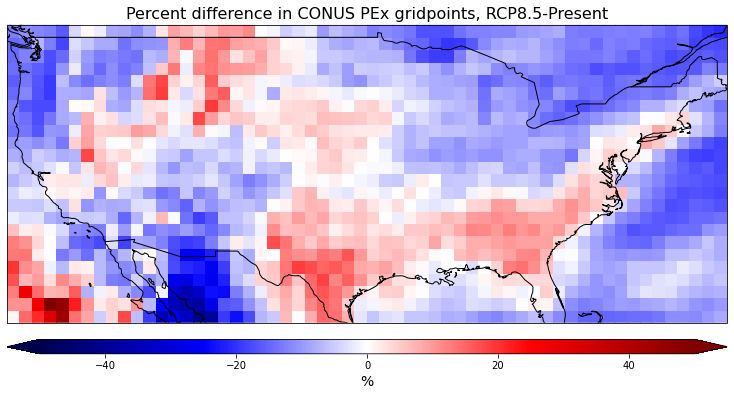

In [105]:
%%time
fig = plt.figure(figsize=(10,10))

ax = fig.add_axes([0.,0.,1.,1.], projection=ccrs.PlateCarree())

ax.coastlines()
ax.add_feature(cfeature.BORDERS)

# discrete colormap
cmap=plt.cm.get_cmap('seismic')

# percent diff
field, lon = add_cyclic_point(spatialperdiff_PEx_CONUS, coord=spatialperdiff_PEx_CONUS.lon)
lat = spatialperdiff_PEx_CONUS.lat

cf = ax.pcolor(lon, lat, field, cmap=cmap, vmin=-50, vmax=50, transform=ccrs.PlateCarree())

# add colorbar
cb_ax = fig.add_axes([0, 0.25, 1, 0.02])
cbar = plt.colorbar(cf, cax=cb_ax, orientation='horizontal', extend='both')
cbar.ax.set_xlabel('%', fontsize=14)

# add title
ax.set_title('Percent difference in CONUS PEx gridpoints, RCP8.5-Present', fontsize=16); 

#plt.savefig('../figures/toSCP/PEx_time_CONUS_perdiff_3ha.png', bbox_inches='tight')

In [99]:
spatialperdiff_PEx_CONUS.mean().values

array(-4.31187855)

### TO DO: Seasonal plots?